In [2]:
import os
import glob
import time

import pandas as pd
import numpy as np
import xarray as xr
import datetime


import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16})

import cartopy.crs as ccrs
import cartopy

from wrfProcessing import *

import sys
p = os.path.abspath('../..')
if p not in sys.path:
    sys.path.append(p)

from tools.generalTools import qsat,humidsat
from orographicConvectionTheory.orographicConvectionTheory import *
from orographicPrecipitation.observationsAndERA5.linearWaveModels import linear_w_1layer,w_to_Tprime,linear_w_generalized
from tools.generalTools import compute_N
from tools.wrfHrTools import *

SCRATCH='/global/cscratch1/sd/qnicolas/'

import metpy.calc as mpcalc
from metpy.plots import SkewT
from metpy.units import units

In [3]:
xr.set_options(display_style='text') 

In [3]:
from dask.distributed import Client
client=Client()

In [13]:
import sys;import os
p = '/global/homes/q/qnicolas'
if p not in sys.path:
    sys.path.append(p)
from tools.wrfHrTools import *

path = "/global/cscratch1/sd/qnicolas/wrfdata/saved/"
sims = ["channel.wrf.100x2.mountain.60lev.500m.12mps.3km",
        "channel.wrf.100x2.mountain.60lev.500m.296K.3km",
        "channel.wrf.100x2.mountain.60lev.500m.3km",
        "channel.wrf.100x2.mountain.60lev.3km",
        "channel.wrf.100x2.mountain.60lev.dry.3km",
        "channel.wrf.100x2.mountain.60lev.500m.12mps.new.3km",
        "channel.wrf.100x2.mountain.60lev.500m.296K.new.3km",
        "channel.wrf.100x2.mountain.60lev.500m.new2.3km",
        "channel.wrf.100x2.mountain.60lev.500m.new.3km",
        ]
for i,sim in enumerate(sims):
    test = extract_wrfout(path+sim+'/')
    test = extract_wrfpro(path+sim+'/')
    if i<5:
        for file in os.listdir(path+sim+"/diags/"):
            try:
                test = xr.open_dataset(path+sim+"/diags/"+file)
            except OSError:
                try:
                    test = xr.open_zarr(path+sim+"/diags/"+file)
                except:
                    print("Could not open "+ path+sim+"/diags/"+file)
                
    if i<3 or (i>=5 and i<8):
        test = xr.open_dataset(path+sim+"/wrfinput_d01")
    

Could not open /global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/diags/old_etalevs
Could not open /global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.dry.3km/diags/old


## Initializations

In [101]:
## new 500m classic run

deepinput500 = xr.open_dataset('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/wrfinput_d01')
deepoutput500 = xr.open_dataset('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/wrfout_d01_1970-07-20_00_00_00_lasttime')

input_vars = [name for name in deepinput500.data_vars]
output_vars = [name for name in deepoutput500.data_vars]
intersec_vars = [name for name in input_vars if name in output_vars]
updated_vars = ['U','V','W','PH','T','MU','P','Q2','T2','TH2','PSFC','U10','V10','QVAPOR','QCLOUD','QRAIN','QICE','QSNOW','QGRAUP','SMOIS','SH2O','SNOW','TSK','TG','CM','CH','T2V','T2B','Q2V','Q2B','TRAD','RUNSF','RUNSB','ECAN','EDIR','ETRAN','FSA','FIRA','TR','EVC']


from netCDF4 import Dataset
ncfile = Dataset('/global/cscratch1/sd/qnicolas/WRF/WRFV4_channel/test/em_beta_plane/wrfinput_d01', 'r+') # for modification
for name in updated_vars:
    ncfile[name][:]=np.array(deepoutput500[name])
ncfile.close()

In [45]:
## new 500m 296K run

deepinput500 = xr.open_dataset('/global/cscratch1/sd/qnicolas/WRF/WRFV4_channel296/test/em_beta_plane/wrfinput_d01')
deepoutput500 = xr.open_dataset('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.296K.3km/wrfout_d01_1970-01-07_06_00_00').isel(Time=slice(7,8))

input_vars = [name for name in deepinput500.data_vars]
output_vars = [name for name in deepoutput500.data_vars]
intersec_vars = [name for name in input_vars if name in output_vars]
updated_vars = ['U','V','W','PH','T','MU','P','Q2','T2','TH2','PSFC','U10','V10','QVAPOR','QCLOUD','QRAIN','QICE','QSNOW','QGRAUP','SMOIS','SH2O','SNOW','TSK','TG','CM','CH','T2V','T2B','Q2V','Q2B','TRAD','RUNSF','RUNSB','ECAN','EDIR','ETRAN','FSA','FIRA','TR','EVC']


from netCDF4 import Dataset
ncfile = Dataset('/global/cscratch1/sd/qnicolas/WRF/WRFV4_channel296/test/em_beta_plane/wrfinput_d01', 'r+') # for modification
for name in updated_vars:
    ncfile[name][:]=np.array(deepoutput500[name])
ncfile.close()

In [8]:
1/250-1/300

0.0006666666666666665

In [1]:
## 500m 296K run
from createSounding import moist_adiabat
z = np.arange(0.,50001,50.)

def moist_adiabat(z,SST):
    p = 1000*np.exp(-9.81*z/(287.*270.)) * units.hPa
    Tp = mpcalc.moist_lapse(p,(SST-1)*units.K)
    qp = 0.8*mpcalc.saturation_mixing_ratio(p,Tp)
    
    ztrop1=17e3
    ztrop2=19e3
    idx1 = np.argmin((z-ztrop1)**2)
    idx2 = np.argmin((z-ztrop2)**2)
    Tp[idx1:idx2] = Tp[idx1]
    Tp[idx2:] = Tp[idx1]+2e-3*(z[idx2:]-ztrop2)*units.K
    thetap = mpcalc.potential_temperature(p,Tp)
    thicknesses = [mpcalc.thickness_hydrostatic(p, Tp,bottom=p[i] ,depth=p[i]-p[i+1])/units.m for i in range(len(p)-1)]
    zp = np.concatenate([[0.],np.cumsum(thicknesses)])
    
    thetaz = np.interp(z,zp,(thetap/units.K))
    qz = np.interp(z,zp,qp)
    idxs = z<35000
    return z[idxs], np.array([float(x) for x in thetaz])[idxs],np.array([float(x) for x in qz])[idxs]

z,thetaz,qz = moist_adiabat(z,SST)

In [17]:
deepinput500new = xr.open_dataset('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.new.3km/wrfinput_d01')
deepinput500 = xr.open_dataset('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/wrfinput_d01')
deepinput50012 = xr.open_dataset('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.12mps.3km/wrfinput_d01')


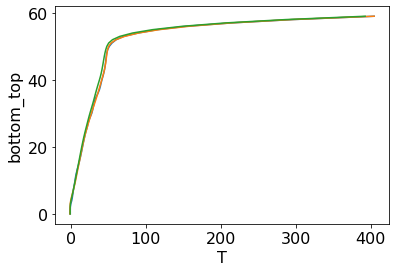

In [27]:
deepinput500new.T[0,:60,0,0].plot(y='bottom_top')
deepinput500new.T[0,:60].mean(['south_north','west_east']).plot(y='bottom_top')

deepinput500.T[0,:60].mean(['south_north','west_east']).plot(y='bottom_top')

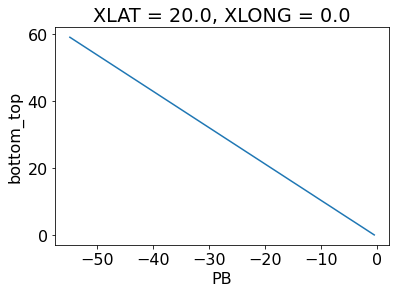

In [26]:
(deepinput500.PB[0,:,0,0]-deepinput50012.PB[0,:,0,0]).plot(y='bottom_top')
#deepinput50012.PHB[0,:,0,0].plot(y='bottom_top_stag')

In [31]:
deepinput500296= xr.open_dataset('/global/cscratch1/sd/qnicolas/WRF/WRFV4_channel296/test/em_beta_plane/wrfinput_d01')


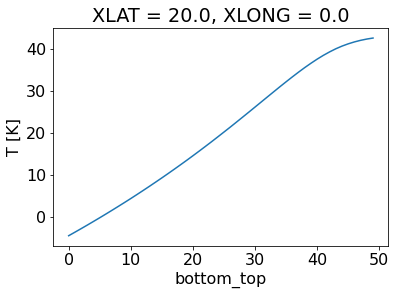

In [36]:
deepinput500296.T[0,:50,0,0].plot()

## Spinups

In [6]:
#%%time
#deepchannel_500 = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/')
#T_hov = deepchannel_500.T.mean(['south_north','west_east']).load()
#Q_hov = deepchannel_500.QVAPOR.mean(['south_north','west_east']).load()
#T_hov.to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/diags/wrf.T.t_z_hovmoeller.nc')
#q_hov.to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/diags/wrf.QVAPOR.t_z_hovmoeller.nc')

In [4]:
T_hov=xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/diags/wrf.T.t_z_hovmoeller.nc')
Tprime_hov = (T_hov-T_hov.isel(Time=0))

In [5]:
%%time
deepinput_500_12 = xr.open_dataset('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.12mps.3km/wrfinput_d01')
deepchannel_500_12 = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.12mps.3km/')
T_hov_12 = deepchannel_500_12.T.mean(['south_north','west_east']).load()
Tprime_hov_12 = (T_hov_12-T_hov_12.isel(Time=0))


CPU times: user 6.61 s, sys: 781 ms, total: 7.39 s
Wall time: 59 s


In [9]:
z_mean = 1/9.81*(deepinput_500_12.PHB.isel(south_north=0,west_east=0,Time=0)+deepchannel_500_12.PH.isel(west_east=slice(2000,3000),Time=slice(-10,-1)).mean(['west_east','south_north','Time'])).load()


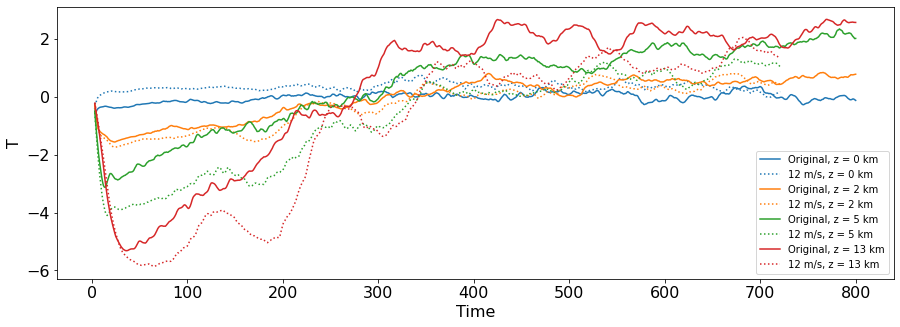

In [20]:
plt.figure(figsize=(15,5))
clrs = plt.rcParams['axes.prop_cycle'].by_key()['color']
for j,i in enumerate((5,15,30,50)):
    Tprime_hov.rolling(Time=4).mean().isel(bottom_top=i).plot(label="Original, z = %i km"%(z_mean[i]/1e3),color=clrs[j])
    Tprime_hov_12.rolling(Time=4).mean().isel(bottom_top=i).plot(label="12 m/s, z = %i km"%(z_mean[i]/1e3),color=clrs[j],linestyle=':')
plt.legend(fontsize=10,loc=4)
#plt.xlim(0,50)

# Functions, data

In [4]:
deepinput_500 = xr.open_dataset('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/wrfinput_d01')
deepchannel_500 = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/')
deepchannel_500_new = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.new.3km/')

deepinput_500_12 = xr.open_dataset('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.12mps.3km/wrfinput_d01')
deepchannel_500_12 = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.12mps.3km/')

deepinput_500_296K = xr.open_dataset('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.296K.3km/wrfinput_d01')
deepchannel_500_296K = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.296K.3km/')


In [5]:
def check_dupes(sim):
    times=sim.Times.load()
    test=list(times.data)
    seen = set()
    dupes = [x for x in test if x in seen or seen.add(x)] 
    print(dupes)
    
check_dupes(deepchannel_500_12)
check_dupes(deepchannel_500_296K)

[]
[b'1970-08-03_06:00:00', b'1970-08-07_06:00:00', b'1970-08-13_06:00:00', b'1970-08-15_06:00:00', b'1970-08-17_06:00:00', b'1970-08-19_06:00:00', b'1970-08-27_06:00:00', b'1970-08-29_06:00:00', b'1970-08-31_06:00:00', b'1970-09-02_06:00:00', b'1970-09-04_06:00:00', b'1970-09-06_06:00:00']


In [6]:
deepchannel_500_p = extract_wrfpro('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/')
#deepchannel_500_new_p  = extract_wrfpro('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.new.3km/')
#deepchannel_500_12_p  = extract_wrfpro('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.12mps.3km/')
#deepchannel_500_296K_p  = extract_wrfpro('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.296K.3km/')


In [7]:
deepchannel_500precip = xr.open_dataarray("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/diags/wrf.precip.days0-200.nc")


In [8]:
hrhgt = deepinput_500.HGT.isel(south_north=0,Time=-1).persist()
hrdist=(1635-hrhgt.west_east)*3

In [4]:
def ratio_CI(pr1,pr2,unit,norm=1):
    pr1=np.array(pr1); pr2=np.array(pr2)
    nt1=len(pr1);nt2=len(pr2)
    sigma1=np.std(pr1.mean(axis=(1,2)));sigma2=np.std(pr2.mean(axis=(1,2)))
    
    meanratio = pr2.mean()/pr1.mean()
    deltaratio = meanratio * np.sqrt( (2*sigma1/np.sqrt(nt1)/pr1.mean())**2 + (2*sigma2/np.sqrt(nt2)/pr2.mean())**2)
    
    print("Change is %.1f %%/%s (95%% CI = [%.1f to %.1f])"%(100*(meanratio-1)/norm,unit,100*(meanratio-1-deltaratio)/norm,100*(meanratio-1+deltaratio)/norm))

In [5]:
def linear_precip_theory_N(xx,hx,U,N,qfact=1,tauT=3,tauq=11,P0=4.,Td_effect=1,m_effect=1):
    pT_ov_g = 8e3 #mass of troposphere in kg/m2
    
    z=np.arange(0,10000,100)
    k=k_vector(len(xx),xx[1]-xx[0])
    
    tauT*=3600
    tauq*=3600
    
    Lq=compute_Lq(5,U,tauq)
    
    _,dq0dz,_ = lapse_rates()
    N0=0.01
    if Td_effect:
        ds0dz = cp*300/g*N**2
    else:
        ds0dz = cp*300/g*N0**2
    chi = pT_ov_g * (ds0dz/tauT - qfact*dq0dz/tauq)/ Lc * 86400
    
    if not m_effect:
        N=N0
    
    zbot=1000
    ztop=3000    
    z_slice = z[np.where((z>=zbot) & (z<=ztop))]
    Pprimehat = 1j*k/(1j*k + 1/Lq) * chi * np.fft.fft(hx) * np.exp( m_exponent(k[:,None],N,U)  *  z_slice[None,:]).mean(axis=1) 
    
    P = P0 + np.real(np.fft.ifft(Pprimehat))
    P = np.maximum(0.,P)
    return P

def linear_TdL_qdL_N(xx,hx,U,N,qfact=1):
    cp = 1004. #Heat capacity of air in J/kg/K

    z=np.arange(0,10000,100)
    k=k_vector(len(xx),xx[1]-xx[0])

    zbot=1000
    ztop=3000
    z_slice = z[np.where((z>=zbot) & (z<=ztop))]

    _,dq0dz,_ = lapse_rates()
    dq0dz *= qfact
    ds0dz = cp*300/g*N**2

    Tdhat = -ds0dz*np.fft.fft(hx)*np.exp( m_exponent(k[:,None],N,U)  *  z_slice[None,:]).mean(axis=1)
    qdhat = -dq0dz*np.fft.fft(hx)*np.exp( m_exponent(k[:,None],N,U)  *  z_slice[None,:]).mean(axis=1)

    return np.real(np.fft.ifft(Tdhat))/cp,np.real(np.fft.ifft(qdhat))/cp

def hatprime(var,idx1,idx2):
    """Vertically average variable between two pressure levels indicated by their indices (idx1 and idx2), and take deviation from upstream value"""
    varhat = var[idx1:idx2].integrate('pressure')/(var.pressure[idx2]-var.pressure[idx1])
    return varhat - varhat[2200:2400].mean('distance_from_mtn')
pT_ov_g=8000
cp=1004.
Lc=2.5e6
g=9.81

In [11]:
def interp_eta_to_pressure(ds,var,staggered=1,plevs=None,dsinput=None):
    """Make sure eta_level is the first dimension"""
    if plevs is None:
        plevs= np.arange(125.,990.,20.)
    if dsinput is None:
        dsinput=ds
    rep=np.zeros((len(plevs),len(var[0])))
    PB_rev = np.array(dsinput.PB[0,:,0]+ds.P[-20:].mean(['Time','south_north']))[::-1]
    var_rev=np.array(var)[::-1]
    if staggered:
        i=0
        ZNW = np.array(ds.ZNW[0])[::-1]
        ZNU=  np.array(ds.ZNU[0])[::-1]
        for i in range(len(var[0])):
            PB_rev_stag = np.interp(ZNW,ZNU,PB_rev[:,i])
            rep[:,i]=np.interp(plevs*100,PB_rev_stag,var_rev[:,i])
            rep[plevs*100>PB_rev_stag[-1],i]=np.nan
    else:
        for i in range(len(var[0])):
            rep[:,i]=np.interp(plevs*100,PB_rev[:,i],var_rev[:,i])
            rep[plevs*100>PB_rev[-1,i],i]=np.nan
    return xr.DataArray(rep[::-1],coords={'pressure':plevs[::-1],'distance_from_mtn':var.distance_from_mtn},dims=['pressure','distance_from_mtn'])

# Sensitivity to U 

## Precipitation

In [12]:
deepchannel_500_newprecip = deepchannel_500_new.RAINNC.diff('Time').load()*4
deepchannel_500_12precip = deepchannel_500_12.RAINNC.diff('Time').load()*4

In [13]:
dp500_12pr = deepchannel_500_12precip[200:].mean(['south_north','Time']).load()
dp500_10pr = 0.5*(deepchannel_500precip[200:].mean(['south_north','Time']).load() + deepchannel_500_newprecip[8:].mean(['south_north','Time']).load())

In [14]:
dp500_12std = deepchannel_500_12precip[200:].mean('south_north').std('Time').load()
dp500_10std = np.sqrt(0.5*(deepchannel_500precip[200:].mean('south_north').std('Time').load()**2 + deepchannel_500_newprecip[8:].mean('south_north').std('Time').load()**2))


In [15]:
xx,hx = topographic_profile('cos',A=500)
Plin_10 = linear_precip_theory(xx,hx,10,7.5,27.5,P0=4.5)
Plin_12 = linear_precip_theory(xx,hx,12,7.5,27.5,P0=4.5)

(-1000.0, 1000.0)

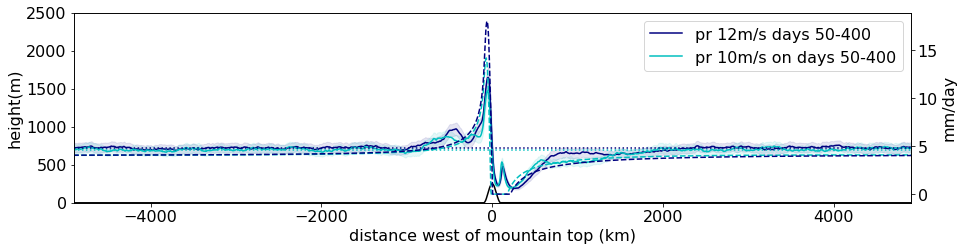

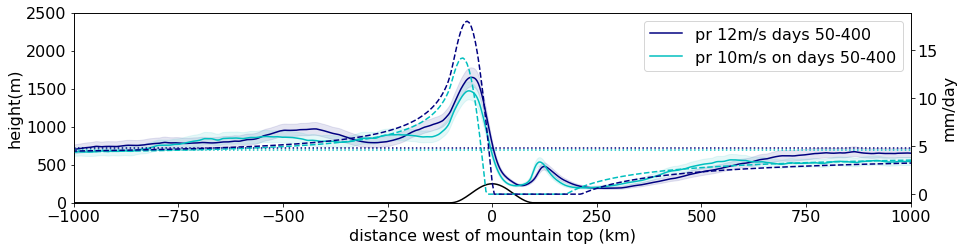

In [20]:
matplotlib.rcParams.update({'font.size':16})
for _ in range(2):
    ax,ax2=plotsection(hrhgt/2,figsize=(15,3.5))
    
    ax2.plot(hrdist,dp500_12pr,color='navy',label='pr 12m/s days 50-400')
    ax2.plot(hrdist,dp500_10pr,color='c',label='pr 10m/s on days 50-400')
    
    ax2.fill_between(hrdist,dp500_12pr-2*dp500_12std/np.sqrt(968),dp500_12pr+2*dp500_12std/np.sqrt(968),alpha=0.1,color='navy')
    ax2.fill_between(hrdist,dp500_10pr-2*dp500_10std/np.sqrt(1283),dp500_10pr+2*dp500_10std/np.sqrt(1283),alpha=0.1,color='c')
    
    ax2.axhline(dp500_12pr[2200:3000].mean(),color='navy',linestyle=':')
    ax2.axhline(dp500_10pr[2200:3000].mean(),color='c'  ,linestyle=':')
    
    ax2.plot(xx/1000,Plin_10,color='c',linestyle='--')
    ax2.plot(xx/1000,Plin_12,color='navy',linestyle='--')
   
    ax2.set_ylabel("mm/day")
    ax2.legend()
    ax.set_xlim(-4900,4900)
    ax.set_ylim(0.,2500.)
ax.set_xlim(-1000,1000)

(0.0, 2500.0)

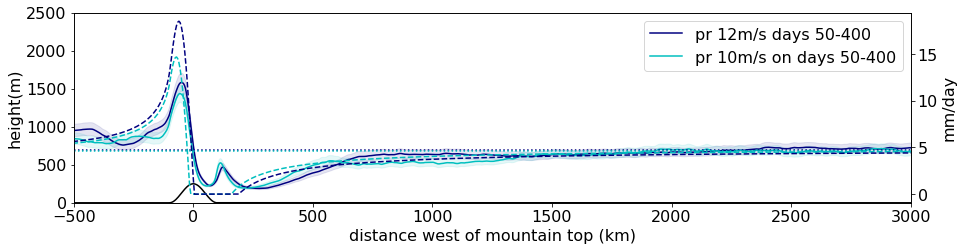

In [16]:
matplotlib.rcParams.update({'font.size':16})
ax,ax2=plotsection(hrhgt/2,figsize=(15,3.5))

ax2.plot(hrdist,dp500_12pr,color='navy',label='pr 12m/s days 50-400')
ax2.plot(hrdist,dp500_10pr,color='c',label='pr 10m/s on days 50-400')

ax2.fill_between(hrdist,dp500_12pr-2*dp500_12std/np.sqrt(968),dp500_12pr+2*dp500_12std/np.sqrt(968),alpha=0.1,color='navy')
ax2.fill_between(hrdist,dp500_10pr-2*dp500_10std/np.sqrt(1060),dp500_10pr+2*dp500_10std/np.sqrt(1060),alpha=0.1,color='c')

ax2.axhline(dp500_12pr[2200:3000].mean(),color='navy',linestyle=':')
ax2.axhline(dp500_10pr[2200:3000].mean(),color='c'  ,linestyle=':')

ax2.plot(xx/1000,Plin_10,color='c',linestyle='--')
ax2.plot(xx/1000,Plin_12,color='navy',linestyle='--')

ax2.set_ylabel("mm/day")
ax2.legend()
ax.set_xlim(-500,3000)
ax.set_ylim(0.,2500.)

In [17]:
%time deepchannel_500concatprecip = xr.concat((deepchannel_500precip[200:],deepchannel_500_newprecip[8:]),dim='Time')


CPU times: user 1.03 s, sys: 4.32 s, total: 5.35 s
Wall time: 5.16 s


In [18]:
peakprecipdp500_10 = deepchannel_500concatprecip[:,:,1651:1656]
peakprecipdp500_12 = deepchannel_500_12precip[200:,:,1649:1654]
upstreamprecipdp500_10 = deepchannel_500concatprecip[:,:,2200:3000].mean()
upstreamprecipdp500_12 = deepchannel_500_12precip[200:,:,2200:3000].mean()
print("Peak precip:", end=' '); ratio_CI(peakprecipdp500_10,peakprecipdp500_12,'(m/s)',norm=2)
print("Peak P':    ", end=' '); ratio_CI(peakprecipdp500_10-upstreamprecipdp500_10,peakprecipdp500_12-upstreamprecipdp500_12,'(m/s)',norm=2)

Peak precip: Change is 5.0 %/(m/s) (95% CI = [-1.1 to 11.2])
Peak P':     Change is 7.5 %/(m/s) (95% CI = [-3.6 to 18.5])


In [22]:
peakprecipdp500_10 = deepchannel_500concatprecip[:,:,1651:1656]
peakprecipdp500_12 = deepchannel_500_12precip[200:,:,1649:1654]
upstreamprecipdp500_10 = deepchannel_500concatprecip[:,:,2200:3000].mean()
upstreamprecipdp500_12 = deepchannel_500_12precip[200:,:,2200:3000].mean()
print("Peak precip:", end=' '); ratio_CI(peakprecipdp500_10,peakprecipdp500_12,'(m/s)',norm=2)
print("Peak P':    ", end=' '); ratio_CI(peakprecipdp500_10-upstreamprecipdp500_10,peakprecipdp500_12-upstreamprecipdp500_12,'(m/s)',norm=2)

Peak precip: Change is 6.0 %/(m/s) (95% CI = [-0.7 to 12.7])
Peak P':     Change is 9.1 %/(m/s) (95% CI = [-2.8 to 21.1])


In [23]:
print("Theoretical change in peak precip: %.1f %%/(m/s)"%(100*(np.max(Plin_12)/np.max(Plin_10)-1)/2))
print("Theoretical change in peak P': %.1f %%/(m/s)"%(100*(np.max(Plin_12-4)/np.max(Plin_10-4)-1)/2))

Theoretical change in peak precip: 13.5 %/(m/s)
Theoretical change in peak P': 18.8 %/(m/s)


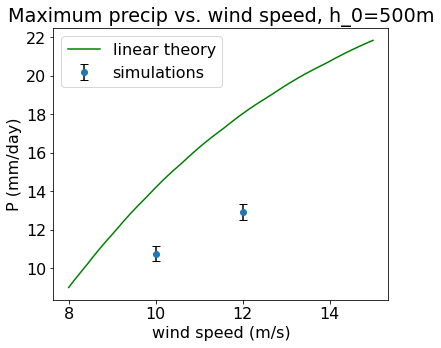

In [170]:
u_array=np.linspace(8,15)
xx,hx = topographic_profile('cos',A=500)
Pmax_array=np.array([np.max(linear_precip_theory(xx,hx,u,7.5,27.5)) for u in u_array])
_,ax=plt.subplots(1,1,figsize=(6,5))
ax.plot(u_array,Pmax_array,color='g',label='linear theory')
ax.set_xlabel('wind speed (m/s)')
ax.set_ylabel('P (mm/day)')
ax.set_title("Maximum precip vs. wind speed, h_0=500m")
ax.errorbar([10,12],[np.max(dp500_10pr),np.max(dp500_12pr)],yerr=[dp500_10std[np.argmax(np.array(dp500_10pr))]/np.sqrt(4*350),dp500_12std[np.argmax(np.array(dp500_12pr))]/np.sqrt(4*350)],fmt='o',ecolor='k',capsize=4,label='simulations')
ax.legend()

## Precip - Smith vs us

In [16]:
xx2,_,Plin_smith_10 = smith_theory(xx,hx,10,5e-3,4.32e-3)
xx2,_,Plin_smith_12 = smith_theory(xx,hx,12,5e-3,4.32e-3)
Plin_smith_10=(4+(Plin_smith_10-4)/2.5)*(Plin_smith_10>0)
Plin_smith_12=(4+(Plin_smith_12-4)/2.5)*(Plin_smith_12>0)

using dry stability, N=0.013 s^-1
using dry stability, N=0.013 s^-1


(-1000.0, 1000.0)

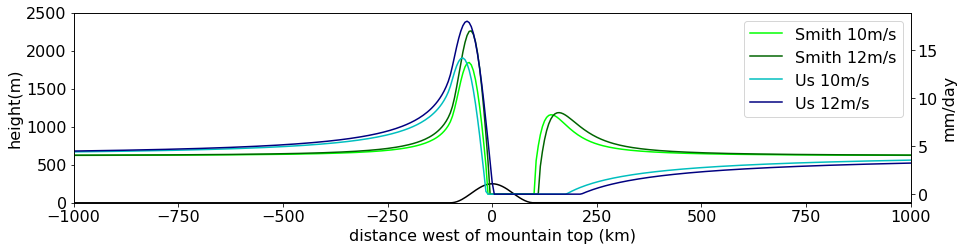

In [20]:
matplotlib.rcParams.update({'font.size':16})
ax,ax2=plotsection(hrhgt/2,figsize=(15,3.5))

ax2.plot(xx2/1000,Plin_smith_10,color='lime',linestyle='-',label='Smith 10m/s')
ax2.plot(xx2/1000,Plin_smith_12,color='darkgreen',linestyle='-',label='Smith 12m/s')

ax2.plot(xx/1000,Plin_10,color='c',linestyle='-',label='Us 10m/s')
ax2.plot(xx/1000,Plin_12,color='navy',linestyle='-',label='Us 12m/s')

ax2.set_ylabel("mm/day")
ax2.legend()
ax.set_xlim(-4900,4900)
ax.set_ylim(0.,2500.)
ax.set_xlim(-1000,1000)

In [18]:
print("Theoretical change in peak precip: %.1f %%/(m/s) (us) vs %.1f %%/(m/s) (smith)"%(100*(np.max(Plin_12)/np.max(Plin_10)-1)/2,100*(np.max(Plin_smith_12)/np.max(Plin_smith_10)-1)/2))
print("Theoretical change in peak P'    : %.1f %%/(m/s) (us) vs %.1f %%/(m/s) (smith)"%(100*(np.max(Plin_12-4)/np.max(Plin_10-4)-1)/2,100*(np.max(Plin_smith_12-4)/np.max(Plin_smith_10-4)-1)/2))



Theoretical change in peak precip: 13.5 %/(m/s) (us) vs 12.0 %/(m/s) (smith)
Theoretical change in peak P'    : 18.8 %/(m/s) (us) vs 16.9 %/(m/s) (smith)


In [21]:
def sensitivity(N0,u0,param):
    """Unit sensitivity (% change in max precip per percent change in input param)"""
    x,hx = topographic_profile(kind='cos')
    Plin   = linear_precip_theory_N(x,hx,u0,N0,tauT=7.5,tauq=27.5,P0 = 4.)-4.
    if param=='N':
        Plin_m = linear_precip_theory_N(x,hx,u0,N0*0.99,tauT=7.5,tauq=27.5,P0 = 4.)-4.
        Plin_p = linear_precip_theory_N(x,hx,u0,N0*1.01,tauT=7.5,tauq=27.5,P0 = 4.)-4.
    elif param=='u':
        Plin_m = linear_precip_theory_N(x,hx,u0*0.99,N0,tauT=7.5,tauq=27.5,P0 = 4.)-4.
        Plin_p = linear_precip_theory_N(x,hx,u0*1.01,N0,tauT=7.5,tauq=27.5,P0 = 4.)-4.
    elif param=='q':
        Plin_m = linear_precip_theory_N(x,hx,u0,N0,qfact=0.99,tauT=7.5,tauq=27.5,P0 = 4.)-4.
        Plin_p = linear_precip_theory_N(x,hx,u0,N0,qfact=1.01,tauT=7.5,tauq=27.5,P0 = 4.)-4.
    else:
        raise ValueError('Param must be N,u or q')
    return (Plin_p.max()-Plin_m.max())/Plin.max() / 0.02
sensitivity = np.vectorize(sensitivity)

In [22]:
N_=np.linspace(1e-2,1.4e-2,20)
u_=np.linspace(8,12,20)
uu,NN = np.meshgrid(u_,N_)
sensitivitiesu = sensitivity(NN,uu,'u')


In [27]:
#import sys; import os
#p = os.path.abspath('../..')
#if p not in sys.path:
#    sys.path.append(p)
#from tools.generalTools import qsat,humidsat

def HwCw(temp_surface,ps,gamma,gamma_m):
    """Compute water vapor scale height and coefficient Cw assuming a moist adiabatic atmosphere
     - temp_surface = surface temperature (np.array)
     - ps = surface pressure (np.array)
     - gamma = environment lapse rate
    """
    L=2.5e6
    Hw = 461.*temp_surface**2/(L*gamma)
    Cw = humidsat(temp_surface,ps/100)[0]*100/287./temp_surface*gamma_m/gamma
    return Hw,Cw

def smith_theory_N(xx,hx,u,N,gamma_m,ts=300.,tau=2000):
    ps=100000.
    gamma_d = 9.81/1004.
    gamma = gamma_d - ts*N**2/9.81
    Hw,Cw = HwCw(ts,ps,gamma,gamma_m)

    tau_c=tau
    tau_f=tau
    P0=4. #mm/day
    
    k=k_vector(len(xx),xx[1]-xx[0])
    
    P=np.maximum(P0+86400*np.real(np.fft.ifft(Cw*np.fft.fft(hx)*1j*u*k/(1-Hw*m_exponent(k,N,u))/(1+1j*u*k*tau_c)/(1+1j*u*k*tau_f))),0.)
    return P

In [28]:
def sensitivity_SB04(N0,u0,param):
    """Unit sensitivity (% change in max precip per percent change in input param)"""
    x,hx = topographic_profile(kind='cos')
    ts0=300.;tsm=297.;tsp=303.
    gamma_m0=4.32;gamma_mm = 4.62;gamma_mp=4.06
    Plin   = smith_theory_N(x,hx,u0,N0,gamma_m0,ts0)-4.
    if param=='N':
        Plin_m = smith_theory_N(x,hx,u0,N0*0.99,gamma_m0,ts0)-4.
        Plin_p = smith_theory_N(x,hx,u0,N0*1.01,gamma_m0,ts0)-4.
    elif param=='u':
        Plin_m = smith_theory_N(x,hx,u0*0.99,N0,gamma_m0,ts0)-4.
        Plin_p = smith_theory_N(x,hx,u0*1.01,N0,gamma_m0,ts0)-4.
    elif param=='T':
        Plin_m = smith_theory_N(x,hx,u0,N0,gamma_mm,tsm)-4.
        Plin_p = smith_theory_N(x,hx,u0,N0,gamma_mp,tsp)-4.
    else:
        raise ValueError('Param must be N,u or T')
    return (Plin_p.max()-Plin_m.max())/Plin.max() / 0.02
sensitivity_SB04 = np.vectorize(sensitivity_SB04)

In [29]:
sensitivitiesu_smith = sensitivity_SB04(NN,uu,'u')


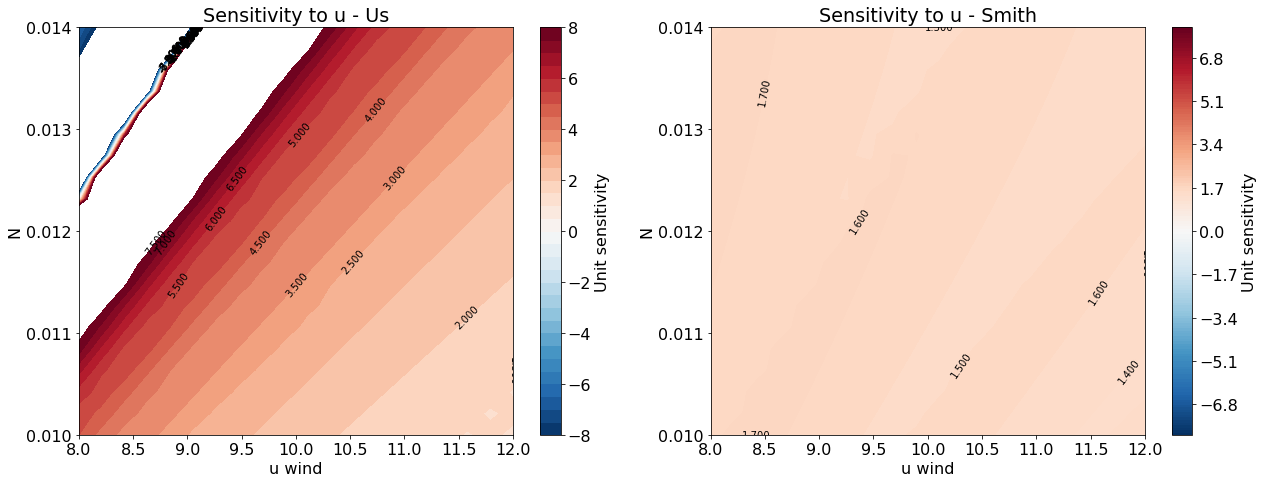

In [37]:
fig,axs=plt.subplots(1,2,figsize=(18,7))

for ax,sens,ttl,lvls in zip(axs,(sensitivitiesu,sensitivitiesu_smith),('u - Us','u - Smith'),(np.arange(-8,8.1,0.5),np.arange(-8,8.1,0.1))):
    cf=ax.contourf(uu,NN,sens,cmap=plt.cm.RdBu_r,levels = lvls)
    fig.colorbar(cf,ax=ax,label='Unit sensitivity')
    cf.clabel(colors='k',fontsize=10,inline=False)
    ax.set_xlabel('u wind')
    ax.set_ylabel('N')
    ax.set_title("Sensitivity to "+ttl)
    ax.set_yticks(np.arange(0.01,0.015,0.001))
fig.tight_layout()

## T,q,w

In [19]:
#deepchannel_500theta = (300+deepchannel_500.T)[200:].mean(['Time','south_north']).load()
#deepchannel_500theta.to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/diags/wrf.THETA.days50-200.nc')
deepchannel_500theta=xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/diags/wrf.THETA.days50-200.nc')

#deepchannel_500_newtheta = (300+deepchannel_500_new.T)[8:].mean(['Time','south_north']).load()
#deepchannel_500_newtheta.to_netcdf('/global/cscratch1/sd/qnicolas/temp/channel.wrf.100x2.mountain.60lev.500m.new.3km.theta_mean_temp.nc')
deepchannel_500_newtheta=xr.open_dataarray('/global/cscratch1/sd/qnicolas/temp/channel.wrf.100x2.mountain.60lev.500m.new.3km.theta_mean_temp.nc')

#deepchannel_500_12theta = (300+deepchannel_500_12.T)[200:].mean(['Time','south_north']).load()
#deepchannel_500_12theta.to_netcdf('/global/cscratch1/sd/qnicolas/temp/channel.wrf.100x2.mountain.60lev.500m.12mps.3km.theta_mean_temp.nc')
deepchannel_500_12theta=xr.open_dataarray('/global/cscratch1/sd/qnicolas/temp/channel.wrf.100x2.mountain.60lev.500m.12mps.3km.theta_mean_temp.nc')

In [20]:
#deepchannel_500qv = deepchannel_500.QVAPOR[200:].mean(['Time','south_north']).load()
#deepchannel_500qv.to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/diags/wrf.QVAPOR.days50-200.nc')
deepchannel_500qv=xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/diags/wrf.QVAPOR.days50-200.nc')

#deepchannel_500_newqv = deepchannel_500_new.QVAPOR[8:].mean(['Time','south_north']).load()
#deepchannel_500_newqv.to_netcdf('/global/cscratch1/sd/qnicolas/temp/channel.wrf.100x2.mountain.60lev.500m.new.3km.qv_mean_temp.nc')
deepchannel_500_newqv=xr.open_dataarray('/global/cscratch1/sd/qnicolas/temp/channel.wrf.100x2.mountain.60lev.500m.new.3km.qv_mean_temp.nc')

#deepchannel_500_12qv = deepchannel_500_12.QVAPOR[200:].mean(['Time','south_north']).load()
#deepchannel_500_12qv.to_netcdf('/global/cscratch1/sd/qnicolas/temp/channel.wrf.100x2.mountain.60lev.500m.12mps.3km.qv_mean_temp.nc')
deepchannel_500_12qv=xr.open_dataarray('/global/cscratch1/sd/qnicolas/temp/channel.wrf.100x2.mountain.60lev.500m.12mps.3km.qv_mean_temp.nc')


In [21]:
deepthetamean_500_10 = change_coords_eta(deepinput_500,0.5*(deepchannel_500_newtheta+deepchannel_500theta))
deepthetamean_500_10_p = interp_eta_to_pressure(deepchannel_500_new,deepthetamean_500_10,0,dsinput=deepinput_500)
deeptempmean_500_10_p = deepthetamean_500_10_p*(deepthetamean_500_10_p.pressure/1e3)**0.286

deepthetamean_500_12_p = interp_eta_to_pressure(deepchannel_500_12,change_coords_eta(deepinput_500_12,deepchannel_500_12theta),0,dsinput=deepinput_500_12)
deeptempmean_500_12_p = deepthetamean_500_12_p*(deepthetamean_500_12_p.pressure/1e3)**0.286

In [22]:
deepqvmean_500_10 = change_coords_eta(deepinput_500,0.5*(deepchannel_500_newqv+deepchannel_500qv))
deepqvmean_500_10_p = interp_eta_to_pressure(deepchannel_500_new,deepqvmean_500_10,0,dsinput=deepinput_500)

deepqvmean_500_12_p = interp_eta_to_pressure(deepchannel_500_12,change_coords_eta(deepinput_500_12,deepchannel_500_12qv),0,dsinput=deepinput_500_12)


In [13]:
p1=5;p2=16
deeptempmean_500_10_p_hat_prime = hatprime(deeptempmean_500_10_p,p1,p2)
deeptempmean_500_12_p_hat_prime = hatprime(deeptempmean_500_12_p,p1,p2)

deepqvmean_500_10_p_hat_prime = Lc/cp*hatprime(deepqvmean_500_10_p,p1,p2) # convert to K
deepqvmean_500_12_p_hat_prime = Lc/cp*hatprime(deepqvmean_500_12_p,p1,p2) # convert to K

xx,hx = topographic_profile(kind='cos',a=100e3,A=500)
lmTd_hat_linear10,lmqd_hat_linear10 = linear_TdL_qdL(xx,hx,10) 
lmTd_hat_linear12,lmqd_hat_linear12 = linear_TdL_qdL(xx,hx,12) 

increase in max, linear theory: T = 17.7%/(m/s),  q = 17.7%/(m/s)
increase in max, WRF: T = 11.4%/(m/s),  q = 14.1%/(m/s)


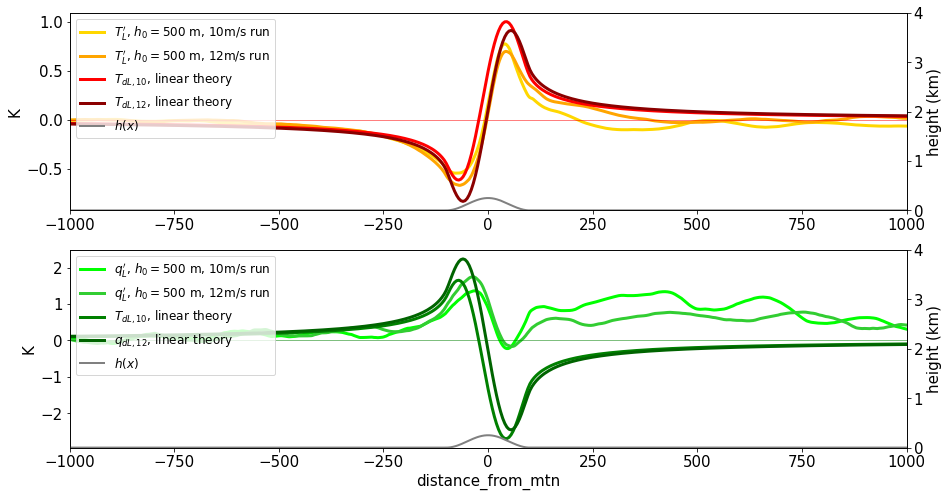

In [16]:
fig,(ax,ax2) = plt.subplots(2,1,figsize=(15,8))
axm=ax.twinx()
ax2m=ax2.twinx()

# Panel a : temperature deviations
deeptempmean_500_10_p_hat_prime.plot(ax=ax,color='gold'  ,linewidth=3,label=r"$T_L'$, $h_0=500$ m, 10m/s run")
deeptempmean_500_12_p_hat_prime.plot(ax=ax,color='orange',linewidth=3,label=r"$T_L'$, $h_0=500$ m, 12m/s run")
ax.plot(xx/1000,lmTd_hat_linear10,   color='red'    ,linewidth=3,label=r"$T_{dL,10}$, linear theory")
ax.plot(xx/1000,lmTd_hat_linear12,   color='darkred',linewidth=3,label=r"$T_{dL,12}$, linear theory")
ax.axhline(0.,linestyle='-',linewidth='0.5',color='red')

# Panel b : moisture deviations
deepqvmean_500_10_p_hat_prime.plot(ax=ax2,color='lime'     ,linewidth=3,label=r"$q_L'$, $h_0=500$ m, 10m/s run")
deepqvmean_500_12_p_hat_prime.plot(ax=ax2,color='limegreen',linewidth=3,label=r"$q_L'$, $h_0=500$ m, 12m/s run")
ax2.plot(xx/1000,lmqd_hat_linear10,   color='green'    ,linewidth=3,label=r"$T_{dL,10}$, linear theory")
ax2.plot(xx/1000,lmqd_hat_linear12,   color='darkgreen',linewidth=3,label=r"$q_{dL,12}$, linear theory")
ax2.axhline(0.,linestyle='-',linewidth='0.5',color='green')


for a,am in (ax,axm),(ax2,ax2m):
    a.set_xlim(-1000,1000)
    a.set_ylabel("K")
    a.legend(fontsize=20)
    
    am.plot(hrdist,hrhgt/2000,label=r"$h(x)$",color='gray',linewidth=2)
    am.set_ylabel('height (km)')
    am.set_ylim(0,4)
    
    lines, labels = a.get_legend_handles_labels()
    lines2, labels2 = am.get_legend_handles_labels()
    a.legend(lines + lines2, labels + labels2,fontsize=12,loc=2)

ax.set_xlabel('')
print("increase in max, linear theory: T = %.1f%%/(m/s),  q = %.1f%%/(m/s)"%(100*(lmTd_hat_linear12.min()/lmTd_hat_linear10.min()-1)/2,100*(lmqd_hat_linear12.max()/lmqd_hat_linear10.max()-1)/2))
print("increase in max, WRF: T = %.1f%%/(m/s),  q = %.1f%%/(m/s)"%(100*(deeptempmean_500_12_p_hat_prime.min()/deeptempmean_500_10_p_hat_prime.min()-1)/2,100*(deepqvmean_500_12_p_hat_prime.max()/deepqvmean_500_10_p_hat_prime.max()-1)/2))


In [23]:
%%time
deepchannel_500w  = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/diags/wrf.W.days50-200.nc')

#deepchannel_500_neww = deepchannel_500_new.W[8:].mean(['Time','south_north']).load()
#deepchannel_500_neww.to_netcdf('/global/cscratch1/sd/qnicolas/temp/channel.wrf.100x2.mountain.60lev.500m.new.3km.w_mean_temp.nc')
deepchannel_500_neww  = xr.open_dataarray('/global/cscratch1/sd/qnicolas/temp/channel.wrf.100x2.mountain.60lev.500m.new.3km.w_mean_temp.nc')

#deepchannel_500_12w = deepchannel_500_12.W[200:].mean(['Time','south_north']).load()
#deepchannel_500_12w.to_netcdf('/global/cscratch1/sd/qnicolas/temp/channel.wrf.100x2.mountain.60lev.500m.12mps.3km.w_mean_temp.nc')
deepchannel_500_12w  = xr.open_dataarray('/global/cscratch1/sd/qnicolas/temp/channel.wrf.100x2.mountain.60lev.500m.12mps.3km.w_mean_temp.nc')

CPU times: user 5.14 ms, sys: 8.98 ms, total: 14.1 ms
Wall time: 129 ms


In [24]:
deepwmean_500_10 = change_coords_eta(deepinput_500,0.5*(deepchannel_500w+deepchannel_500_neww),staggered=True)
deepwmean_500_10_p = interp_eta_to_pressure(deepchannel_500_new,deepwmean_500_10,1,dsinput=deepinput_500)

deepwmean_500_12_p = interp_eta_to_pressure(deepchannel_500_12,change_coords_eta(deepinput_500_12,deepchannel_500_12w,staggered=True),1,dsinput=deepinput_500_12)

In [137]:
xx,hx = topographic_profile(kind='cos',a=100e3,A=500)
linear_w_10 = linear_w_1layer(xx,hx,np.arange(0,20000,200.),10,0.012) 
linear_w_12 = linear_w_1layer(xx,hx,np.arange(0,20000,200.),12,0.012) 


(-0.07, 0.07)

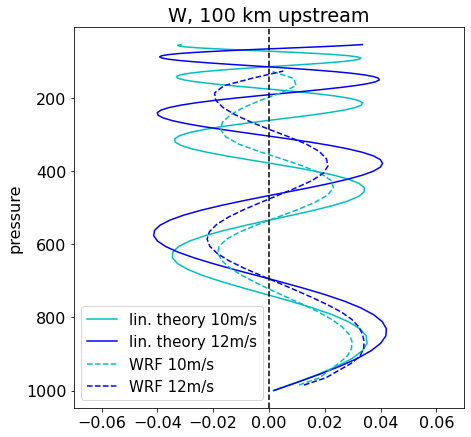

In [169]:
_,ax=plt.subplots(1,1,figsize=(7,7))

linear_w_10.sel(distance_from_mtn=-100,method='nearest').plot(ax=ax,y='pressure',yincrease=False,color='c',label='lin. theory 10m/s')
linear_w_12.sel(distance_from_mtn=-100,method='nearest').plot(ax=ax,y='pressure',yincrease=False,color='b',label='lin. theory 12m/s')

deepwmean_500_10_p.sel(distance_from_mtn=-100,method='nearest').plot(ax=ax,y='pressure',yincrease=False,color='c',linestyle='--',label='WRF 10m/s')
deepwmean_500_12_p.sel(distance_from_mtn=-100,method='nearest').plot(ax=ax,y='pressure',yincrease=False,color='b',linestyle='--',label='WRF 12m/s')
ax.axvline(0.,color='k',linestyle='--')
ax.set_title("W, 100 km upstream")
ax.legend(fontsize=15)
ax.set_xlim(-0.07,0.07)

(0.005, 0.015)

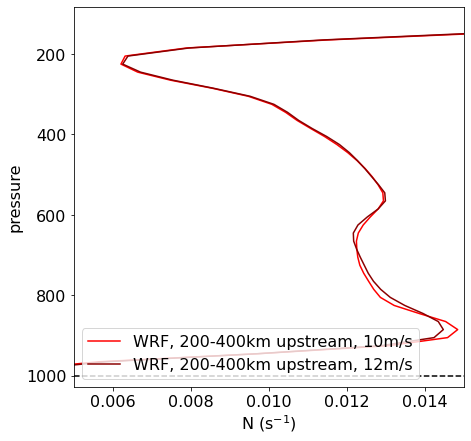

In [140]:
fig,ax = plt.subplots(1,1,figsize=(7,7))
compute_N(deeptempmean_500_10_p.sel(distance_from_mtn=slice(-200,-400)).mean('distance_from_mtn'),100).plot(ax=ax,y='pressure',yincrease=False,color='red'    ,label='WRF, 200-400km upstream, 10m/s')
compute_N(deeptempmean_500_12_p.sel(distance_from_mtn=slice(-200,-400)).mean('distance_from_mtn'),100).plot(ax=ax,y='pressure',yincrease=False,color='darkred',label='WRF, 200-400km upstream, 12m/s')

ax.set_xlabel(r"N (s$^{-1})$")
ax.axvline(0.,color='k',linestyle='--')
ax.axhline(1000.,color='k',linestyle='--')
ax.legend()
ax.set_xlim(0.005,0.015)

## Breaking down the T' and q' sensitivities in WRF

Text(0.5, 1.0, "$q'_{12 m/s}-q'_{10 m/s}$")

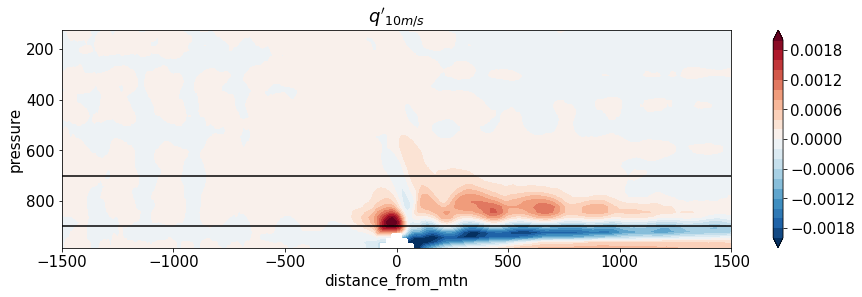

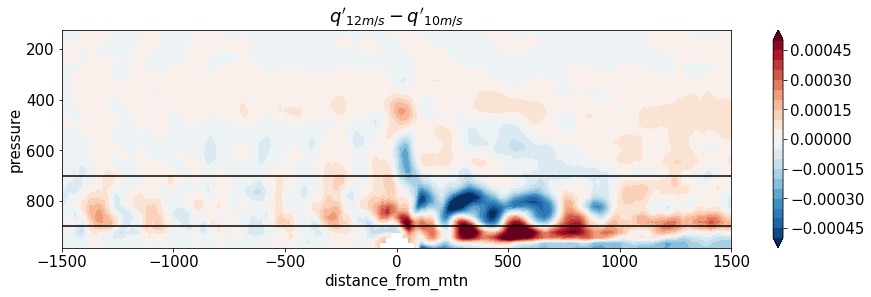

In [19]:
qvprime12 = (deepqvmean_500_12_p-deepqvmean_500_12_p[:,2200:2400].mean('distance_from_mtn'))
qvprime10 = (deepqvmean_500_10_p-deepqvmean_500_10_p[:,2200:2400].mean('distance_from_mtn'))

plt.figure(figsize=(15,4))
qvprime10.plot.contourf(yincrease=False,levels=np.linspace(-2e-3,2e-3,21))
plt.xlim(-1500,1500);plt.axhline(700.,color='k');plt.axhline(900.,color='k')
plt.title(r"$q'_{10 m/s}$")

plt.figure(figsize=(15,4))
(qvprime12-qvprime10).plot.contourf(yincrease=False,levels=np.linspace(-5e-4,5e-4,21))
plt.xlim(-1500,1500);plt.axhline(700.,color='k');plt.axhline(900.,color='k')
plt.title(r"$q'_{12 m/s}-q'_{10 m/s}$")

Text(0.5, 1.0, "$T'_{12 m/s}-T'_{10 m/s}$")

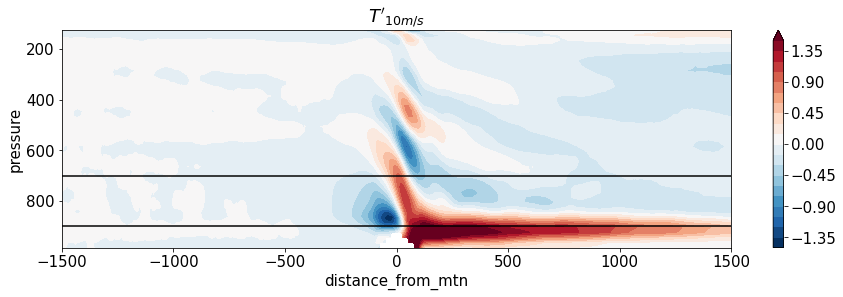

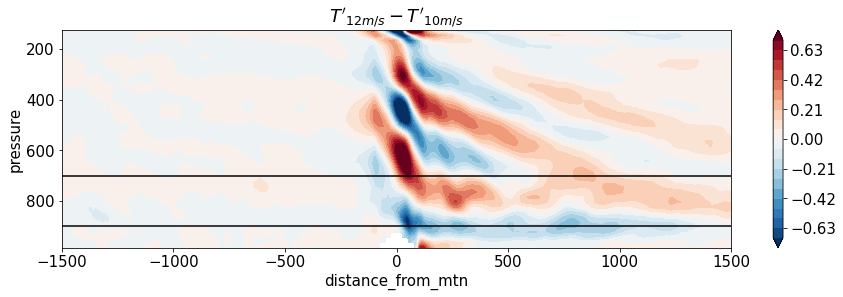

In [25]:
tprime12 = (deeptempmean_500_12_p-deeptempmean_500_12_p[:,2200:2400].mean('distance_from_mtn'))
tprime10 = (deeptempmean_500_10_p-deeptempmean_500_10_p[:,2200:2400].mean('distance_from_mtn'))

plt.figure(figsize=(15,4))
tprime10.plot.contourf(yincrease=False,levels=np.linspace(-1.5,1.5,21))
plt.xlim(-1500,1500);plt.axhline(700.,color='k');plt.axhline(900.,color='k')
plt.title(r"$T'_{10 m/s}$")

plt.figure(figsize=(15,4))
(tprime12-tprime10).plot.contourf(yincrease=False,levels=np.linspace(-0.7,0.7,21))
plt.xlim(-1500,1500);plt.axhline(700.,color='k');plt.axhline(900.,color='k')
plt.title(r"$T'_{12 m/s}-T'_{10 m/s}$")

In [86]:
xx,hx = topographic_profile(kind='cos',a=100e3,A=500)
linear_w_10 = linear_w_1layer(xx,hx,np.arange(0,20000,200.),10,0.012) 
linear_w_12 = linear_w_1layer(xx,hx,np.arange(0,20000,200.),12,0.012) 
linear_tprime_10 = w_to_Tprime(linear_w_10,10,0.012)
linear_tprime_12 = w_to_Tprime(linear_w_12,12,0.012)

(1000.0, 150.0)

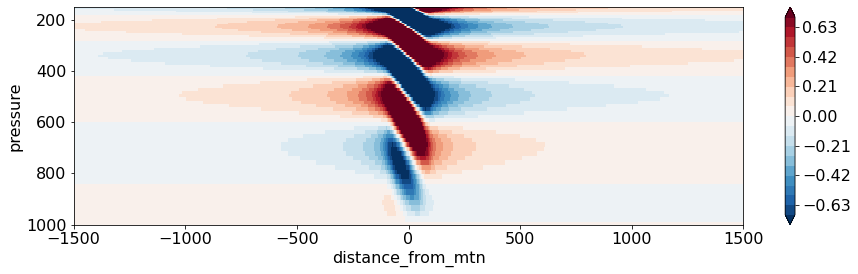

In [90]:
plt.figure(figsize=(15,4))
(linear_tprime_12-linear_tprime_10).plot(y='pressure',yincrease=False,levels=np.linspace(-0.7,0.7,21))
plt.xlim(-1500,1500)
plt.ylim(1000,150)

In [26]:
# Get U interpd on pressure levels
import wrf;from scipy.integrate import cumtrapz
deepchannel_500u = deepchannel_500_new.U[-48:].mean(['Time','south_north']).load()
deepchannel_500u = xr.DataArray(wrf.destagger(deepchannel_500u,1),coords=deepchannel_500qv.coords,dims=deepchannel_500qv.dims)
deepumean_500_10 = change_coords_eta(deepinput_500,deepchannel_500u,staggered=False)
deepumean_500_10_p = interp_eta_to_pressure(deepchannel_500_new,deepumean_500_10,0,dsinput=deepinput_500)

deepchannel_500_12u = deepchannel_500_12.U[-48:].mean(['Time','south_north']).load()
deepchannel_500_12u = xr.DataArray(wrf.destagger(deepchannel_500_12u,1),coords=deepchannel_500qv.coords,dims=deepchannel_500qv.dims)
deepumean_500_12 = change_coords_eta(deepinput_500_12,deepchannel_500_12u,staggered=False)
deepumean_500_12_p = interp_eta_to_pressure(deepchannel_500_12,deepumean_500_12,0,dsinput=deepinput_500_12)


In [27]:
# Get RHO interpd on pressure levels
deepchannel_500rho = deepchannel_500_new.RHO[-48:].mean(['Time','south_north']).load()
deepchannel_500rho = xr.DataArray(deepchannel_500rho,coords=deepchannel_500qv.coords,dims=deepchannel_500qv.dims)
deeprhomean_500_10 = change_coords_eta(deepinput_500,deepchannel_500rho,staggered=False)
deeprhomean_500_10_p = interp_eta_to_pressure(deepchannel_500_new,deeprhomean_500_10,0,dsinput=deepinput_500)

deepchannel_500_12rho = deepchannel_500_12.RHO[-48:].mean(['Time','south_north']).load()
deepchannel_500_12rho = xr.DataArray(deepchannel_500_12rho,coords=deepchannel_500qv.coords,dims=deepchannel_500qv.dims)
deeprhomean_500_12 = change_coords_eta(deepinput_500_12,deepchannel_500_12rho,staggered=False)
deeprhomean_500_12_p = interp_eta_to_pressure(deepchannel_500_12,deeprhomean_500_12,0,dsinput=deepinput_500_12)

In [74]:
# Get thermo budget terms

pi10 = (deeptempmean_500_10_p.pressure/1e3)**0.286
omegadsdp10 = -9.81*deepwmean_500_10_p*deeprhomean_500_10_p*pi10*deepthetamean_500_10_p.differentiate('pressure')/100 
Tprime_diag10 = -xr.DataArray(cumtrapz((omegadsdp10/(-deepumean_500_10_p))[:,::-1],omegadsdp10.distance_from_mtn[::-1]*1e3,axis=-1,initial=0)[:,::-1],coords=deepwmean_500_10_p.coords,dims=deepwmean_500_10_p.dims)
Tprime_diag10=Tprime_diag10-Tprime_diag10[:,2200:2400].mean('distance_from_mtn')
residual10 = -deepumean_500_10_p*deeptempmean_500_10_p.differentiate('distance_from_mtn')/1e3 + omegadsdp10

pi12 = (deeptempmean_500_12_p.pressure/1e3)**0.286
omegadsdp12 = -9.81*deepwmean_500_12_p*deeprhomean_500_12_p*pi12*deepthetamean_500_12_p.differentiate('pressure')/100 
Tprime_diag12 = -xr.DataArray(cumtrapz((omegadsdp12/(-deepumean_500_12_p))[:,::-1],omegadsdp12.distance_from_mtn[::-1]*1e3,axis=-1,initial=0)[:,::-1],coords=deepwmean_500_12_p.coords,dims=deepwmean_500_12_p.dims)
Tprime_diag12=Tprime_diag12-Tprime_diag12[:,2200:2400].mean('distance_from_mtn')
residual12 = -deepumean_500_12_p*deeptempmean_500_12_p.differentiate('distance_from_mtn')/1e3 + omegadsdp12


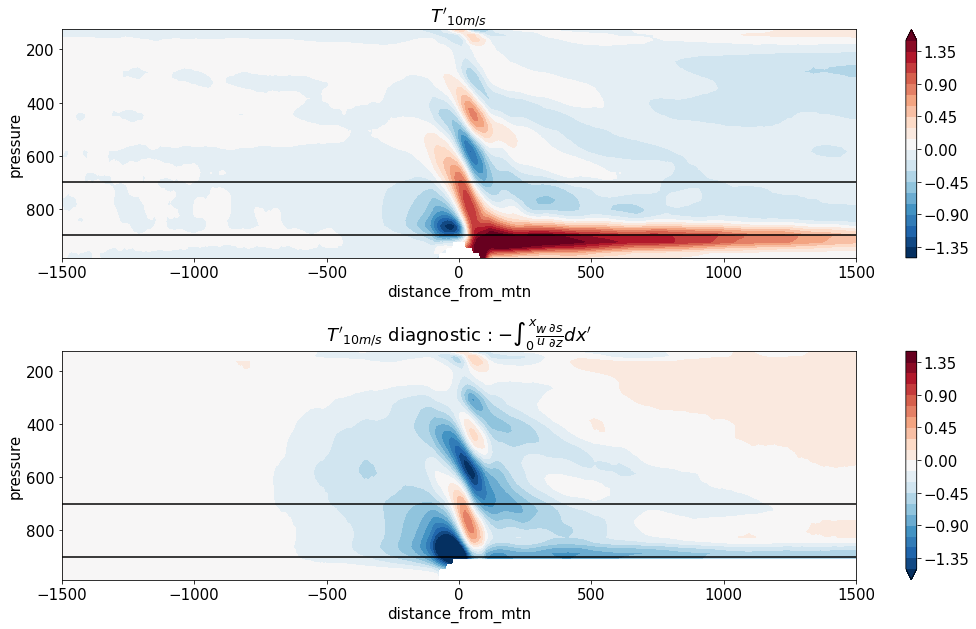

In [51]:
fig,axs = plt.subplots(2,1,figsize=(15,9))
ax=axs[0]
tprime10.plot.contourf(ax=ax,yincrease=False,levels=np.linspace(-1.5,1.5,21))
ax.set_xlim(-1500,1500);ax.axhline(700.,color='k');ax.axhline(900.,color='k')
ax.set_title(r"$T'_{10 m/s}$")

ax=axs[1]
Tprime_diag10.plot.contourf(ax=ax,yincrease=False,levels=np.linspace(-1.5,1.5,21))
ax.set_xlim(-1500,1500);ax.axhline(700.,color='k');ax.axhline(900.,color='k')
ax.set_title(r"$T'_{10 m/s}$ diagnostic : $-\int_0^x \frac{w}{u}\frac{\partial s}{\partial z}dx'$")
fig.tight_layout()

Text(0.5, 1.0, '$u\\frac{\\partial T}{\\partial x}+w\\frac{\\partial s}{\\partial z}$, 12 m/s')

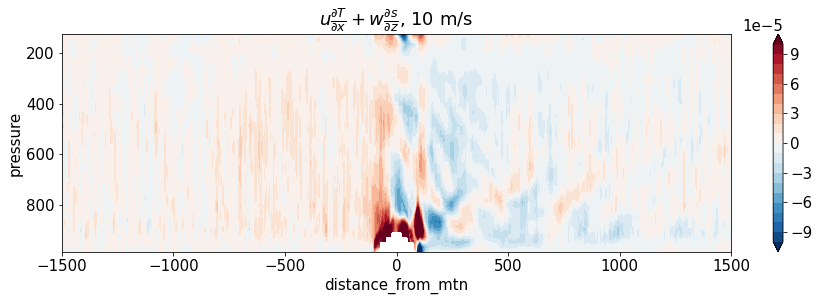

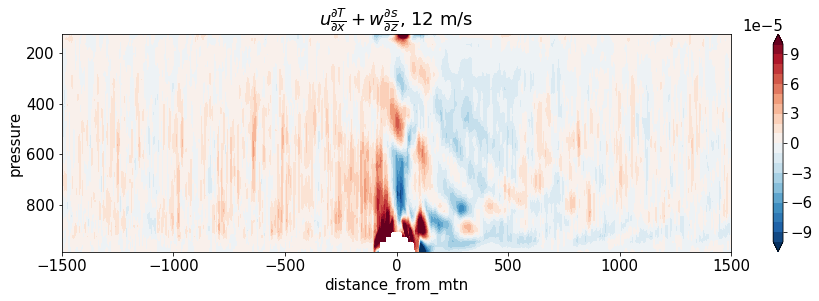

In [52]:
plt.figure(figsize=(15,4))
residual10.plot.contourf(yincrease=False,levels=np.linspace(-1e-4,1e-4,21))
plt.xlim(-1500,1500);plt.title(r"$u\frac{\partial T}{\partial x}+w\frac{\partial s}{\partial z}$, 10 m/s")

plt.figure(figsize=(15,4))
residual12.plot.contourf(yincrease=False,levels=np.linspace(-1e-4,1e-4,21))
plt.xlim(-1500,1500);plt.title(r"$u\frac{\partial T}{\partial x}+w\frac{\partial s}{\partial z}$, 12 m/s")

In [81]:
Tprime_diag10_fixu = -xr.DataArray(cumtrapz((omegadsdp10/10)[:,::-1],omegadsdp10.distance_from_mtn[::-1]*1e3,axis=-1,initial=0)[:,::-1],coords=deepwmean_500_10_p.coords,dims=deepwmean_500_10_p.dims)
Tprime_diag10_fixu=Tprime_diag10_fixu-Tprime_diag10_fixu[:,2200:2400].mean('distance_from_mtn')

Tprime_diag12_fixu = -xr.DataArray(cumtrapz((omegadsdp12/12)[:,::-1],omegadsdp12.distance_from_mtn[::-1]*1e3,axis=-1,initial=0)[:,::-1],coords=deepwmean_500_12_p.coords,dims=deepwmean_500_12_p.dims)
Tprime_diag12_fixu=Tprime_diag12_fixu-Tprime_diag12_fixu[:,2200:2400].mean('distance_from_mtn')


In [86]:
dsdz_fixed = (deeptempmean_500_10_p.differentiate('pressure')/zmean_p.differentiate('pressure') + 9.81/1004)[:,2200:2400].mean('distance_from_mtn')

Tprime_diag10_fixu_fixdsdz = -xr.DataArray(cumtrapz((deepwmean_500_10_p*dsdz_fixed/10)[:,::-1],omegadsdp10.distance_from_mtn[::-1]*1e3,axis=-1,initial=0)[:,::-1],coords=deepwmean_500_10_p.coords,dims=deepwmean_500_10_p.dims)
Tprime_diag10_fixu_fixdsdz=Tprime_diag10_fixu_fixdsdz-Tprime_diag10_fixu_fixdsdz[:,2200:2400].mean('distance_from_mtn')

Tprime_diag12_fixu_fixdsdz = -xr.DataArray(cumtrapz((deepwmean_500_12_p*dsdz_fixed/12)[:,::-1],omegadsdp12.distance_from_mtn[::-1]*1e3,axis=-1,initial=0)[:,::-1],coords=deepwmean_500_12_p.coords,dims=deepwmean_500_12_p.dims)
Tprime_diag12_fixu_fixdsdz=Tprime_diag12_fixu_fixdsdz-Tprime_diag12_fixu_fixdsdz[:,2200:2400].mean('distance_from_mtn')


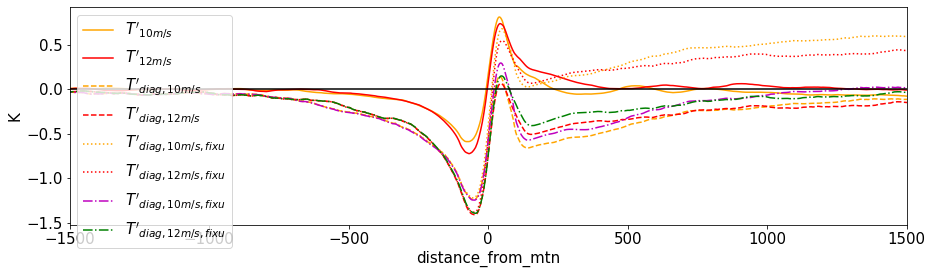

In [87]:
plt.figure(figsize=(15,4))
tprime10[5:16].mean('pressure').plot(color='orange',label=r"$T'_{10 m/s}$")
tprime12[5:16].mean('pressure').plot(color='red' ,label=r"$T'_{12 m/s}$")

Tprime_diag10[5:16].mean('pressure').plot(color='orange',linestyle='--',label=r"$T'_{diag,10 m/s}$")
Tprime_diag12[5:16].mean('pressure').plot(color='red' ,linestyle='--',label=r"$T'_{diag,12 m/s}$")

Tprime_diag10_fixu[5:16].mean('pressure').plot(color='orange',linestyle=':',label=r"$T'_{diag,10 m/s,fix u}$")
Tprime_diag12_fixu[5:16].mean('pressure').plot(color='red'   ,linestyle=':',label=r"$T'_{diag,12 m/s,fix u}$")

Tprime_diag10_fixu_fixdsdz[5:16].mean('pressure').plot(color='m',linestyle='-.',label=r"$T'_{diag,10 m/s,fix u}$")
Tprime_diag12_fixu_fixdsdz[5:16].mean('pressure').plot(color='g'   ,linestyle='-.',label=r"$T'_{diag,12 m/s,fix u}$")


plt.axhline(0.,color='k')
plt.ylabel('K')
plt.xlim(-1500,1500)
plt.title("")
plt.legend(loc=2)

In [63]:
tprime12[5:16].mean('pressure').min()/tprime10[5:16].mean('pressure').min()

<xarray.DataArray ()>
array(1.22640753)

In [62]:
Tprime_diag12[5:16].mean('pressure').min()/Tprime_diag10[5:16].mean('pressure').min()

<xarray.DataArray ()>
array(1.1387372)

In [88]:
Tprime_diag12_fixu_fixdsdz[5:16].mean('pressure').min()/Tprime_diag10_fixu_fixdsdz[5:16].mean('pressure').min()

<xarray.DataArray ()>
array(1.11859224)

## Transients?

In [ ]:
deepinput_500 = xr.open_dataset('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/wrfinput_d01')
deepchannel_500_new = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.new.3km/')


In [ ]:
zmean = 1/9.81*(deepinput_500.PHB[0,:,0]+deepchannel_500_new.PH[-48:].mean(['Time','south_north']))
zmean = change_coords_eta(deepinput_500,zmean,staggered=True)
zmean_p = interp_eta_to_pressure(deepchannel_500_new,zmean,1,dsinput=deepinput_500)


In [ ]:
import wrf

In [ ]:
# Get u, destagger, subtract mean
u = xr.DataArray(wrf.destagger(deepchannel_500_new.U[-48:],3),coords=deepchannel_500_new.T[-48:].coords,dims=deepchannel_500_new.T[-48:].dims)
u = change_coords_eta(deepinput_500,u,staggered=False)
up = u - u.mean(['Time','south_north'])

In [ ]:
# Get theta
theta = (300+deepchannel_500_new.T[-48:])
theta = change_coords_eta(deepinput_500,theta,staggered=False)
press = (deepinput_500.PB[0,:,0]+deepchannel_500_new.P[-48:]).mean(['Time','south_north'])
press = change_coords_eta(deepinput_500,press,staggered=False)
t = theta*(press/1e5)**0.286
tp = t - t.mean(['Time','south_north'])

In [ ]:
# Get w
w = xr.DataArray(wrf.destagger(deepchannel_500_new.W[-48:],1),coords=deepchannel_500_new.T[-48:].coords,dims=deepchannel_500_new.T[-48:].dims)
w = change_coords_eta(deepinput_500,w,staggered=False)
wp = w - w.mean(['Time','south_north'])

In [ ]:
ddx_uptp = ((up*tp).differentiate('distance_from_mtn')/1e3).mean(['Time','south_north'])
ddx_uptp = interp_eta_to_pressure(deepchannel_500_new,ddx_uptp,0,dsinput=deepinput_500)

In [ ]:
wptp_mean = (wp*tp).mean(['Time','south_north']).load()
wptp_mean = interp_eta_to_pressure(deepchannel_500_new,wptp_mean,0,dsinput=deepinput_500)
ddz_wptp = (wptp_mean.differentiate('pressure')/zmean_p.differentiate('pressure'))

In [ ]:
ddx_uptp.to_netcdf('/global/cscratch1/sd/qnicolas/temp/wrf.10mps.ddx_uptp.nc')
ddz_wptp.to_netcdf('/global/cscratch1/sd/qnicolas/temp/wrf.10mps.ddz_wptp.nc')

Text(0.5, 1.0, "-($\\frac{\\partial <u'T'>}{\\partial x}+\\frac{\\partial <w'T'>}{\\partial z})$, 10 m/s")

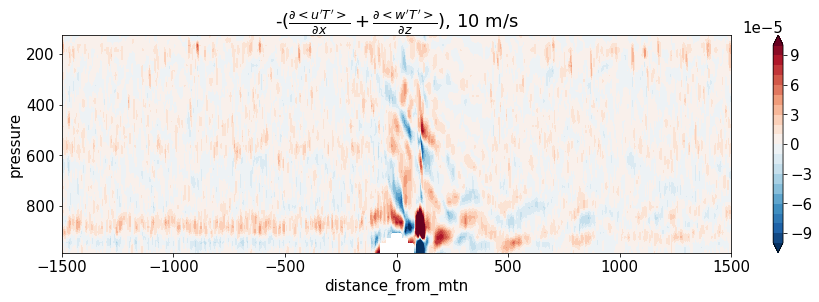

In [72]:
plt.figure(figsize=(15,4))
(-ddx_uptp-ddz_wptp).plot.contourf(yincrease=False,levels=np.linspace(-1e-4,1e-4,21))
plt.xlim(-1500,1500);plt.title(r"-($\frac{\partial <u'T'>}{\partial x}+\frac{\partial <w'T'>}{\partial z})$, 10 m/s")


Text(0.5, 1.0, '$u\\frac{\\partial T}{\\partial x}+w\\frac{\\partial s}{\\partial z}$, 10 m/s')

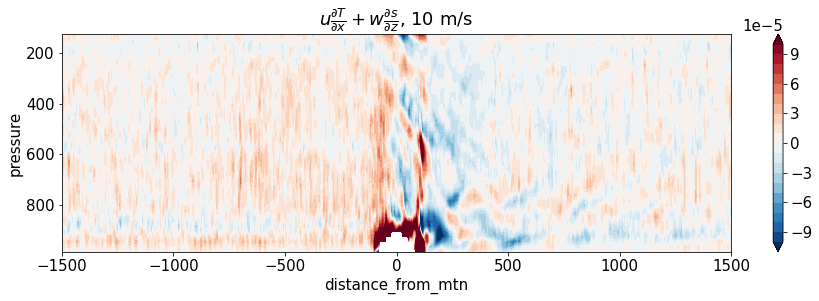

In [69]:
plt.figure(figsize=(15,4))
(residual10+ddx_uptp+ddz_wptp).plot.contourf(yincrease=False,levels=np.linspace(-1e-4,1e-4,21))
plt.xlim(-1500,1500);plt.title(r"$u\frac{\partial T}{\partial x}+w\frac{\partial s}{\partial z}$, 10 m/s")


# Thermodynamic sensitivity

In [ ]:
#deepchannel_500_296Ktheta = (300+deepchannel_500_296K.T)[200:].mean(['Time','south_north']).load()
#deepchannel_500_296Kqv = deepchannel_500_296K.QVAPOR[200:].mean(['Time','south_north']).load()

#deepchannel_500_296Ktheta.to_netcdf('/global/cscratch1/sd/qnicolas/temp/channel.wrf.100x2.mountain.60lev.500m.296K.3km.theta_mean_temp.nc')
#deepchannel_500_296Kqv.to_netcdf('/global/cscratch1/sd/qnicolas/temp/channel.wrf.100x2.mountain.60lev.500m.296K.3km.qv_mean_temp.nc')


In [12]:
deepchannel_500theta=xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/diags/wrf.THETA.days50-200.nc')
deepchannel_500_newtheta=xr.open_dataarray('/global/cscratch1/sd/qnicolas/temp/channel.wrf.100x2.mountain.60lev.500m.new.3km.theta_mean_temp.nc')
deepchannel_500_296Ktheta=xr.open_dataarray('/global/cscratch1/sd/qnicolas/temp/channel.wrf.100x2.mountain.60lev.500m.296K.3km.theta_mean_temp.nc')

In [13]:
deepchannel_500qv=xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/diags/wrf.QVAPOR.days50-200.nc')
deepchannel_500_newqv=xr.open_dataarray('/global/cscratch1/sd/qnicolas/temp/channel.wrf.100x2.mountain.60lev.500m.new.3km.qv_mean_temp.nc')
deepchannel_500_296Kqv=xr.open_dataarray('/global/cscratch1/sd/qnicolas/temp/channel.wrf.100x2.mountain.60lev.500m.296K.3km.qv_mean_temp.nc')


In [14]:
deepthetamean_500_10 = change_coords_eta(deepinput_500,0.5*(deepchannel_500_newtheta+deepchannel_500theta))
deepthetamean_500_10_p = interp_eta_to_pressure(deepchannel_500_new,deepthetamean_500_10,0,dsinput=deepinput_500)
deeptempmean_500_10_p = deepthetamean_500_10_p*(deepthetamean_500_10_p.pressure/1e3)**0.286

deepthetamean_500_296K_p = interp_eta_to_pressure(deepchannel_500_296K,change_coords_eta(deepinput_500_296K,deepchannel_500_296Ktheta),0,dsinput=deepinput_500_296K)
deeptempmean_500_296K_p = deepthetamean_500_296K_p*(deepthetamean_500_296K_p.pressure/1e3)**0.286

In [15]:
deepqvmean_500_10 = change_coords_eta(deepinput_500,0.5*(deepchannel_500_newqv+deepchannel_500qv))
deepqvmean_500_10_p = interp_eta_to_pressure(deepchannel_500_new,deepqvmean_500_10,0,dsinput=deepinput_500)

deepqvmean_500_296K_p = interp_eta_to_pressure(deepchannel_500_296K,change_coords_eta(deepinput_500_296K,deepchannel_500_296Kqv),0,dsinput=deepinput_500_296K)


## N,dq/dz

Fractional change (900-700hPa mean): 1.87 %/K


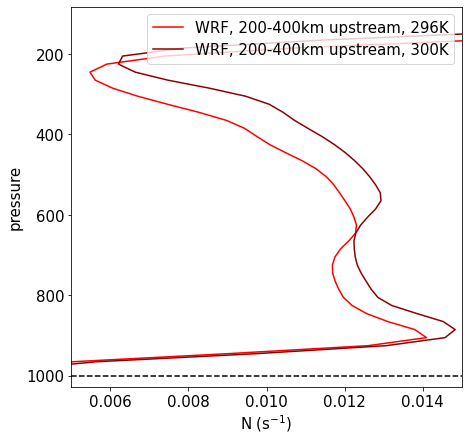

In [16]:
fig,ax = plt.subplots(1,1,figsize=(7,7))
N_296K = compute_N(deeptempmean_500_296K_p.sel(distance_from_mtn=slice(-200,-400)).mean('distance_from_mtn'),100)
N_300K = compute_N(deeptempmean_500_10_p.sel(distance_from_mtn=slice(-200,-400)).mean('distance_from_mtn'),100)  
N_296K.plot(ax=ax,y='pressure',yincrease=False,color='red',label='WRF, 200-400km upstream, 296K')
N_300K.plot(ax=ax,y='pressure',yincrease=False,color='darkred'    ,label='WRF, 200-400km upstream, 300K')

ax.set_xlabel(r"N (s$^{-1})$")
ax.axvline(0.,color='k',linestyle='--')
ax.axhline(1000.,color='k',linestyle='--')
ax.legend()
ax.set_xlim(0.005,0.015)

print("Fractional change (900-700hPa mean): %.2f %%/K"%((N_300K.sel(pressure=slice(900,700)).mean()/N_296K.sel(pressure=slice(900,700)).mean()-1)*100/4))


Fractional change (900-700hPa mean): 8.34 %/K
Fractional change (surface): 7.30 %/K


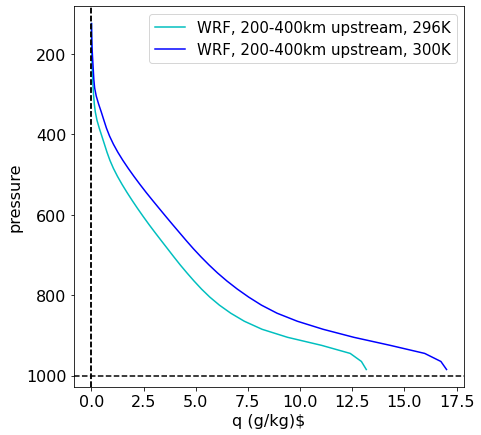

In [37]:
fig,ax = plt.subplots(1,1,figsize=(7,7))
q_296 = deepqvmean_500_296K_p.sel(distance_from_mtn=slice(-200,-400)).mean('distance_from_mtn')
q_300 = deepqvmean_500_10_p.sel(distance_from_mtn=slice(-200,-400)).mean('distance_from_mtn')
(1e3*q_296).plot(ax=ax,y='pressure',yincrease=False,color='c'    ,label='WRF, 200-400km upstream, 296K')
(1e3*q_300).plot(ax=ax,y='pressure',yincrease=False,color='b',label='WRF, 200-400km upstream, 300K')

ax.axvline(0.,color='k',linestyle='--')
ax.set_xlabel(r"q (g/kg)$")
ax.axvline(0.,color='k',linestyle='--')
ax.axhline(1000.,color='k',linestyle='--')
ax.legend(fontsize=15)

print("Fractional change (900-700hPa mean): %.2f %%/K"%((q_300.sel(pressure=slice(900,700)).mean()/q_296.sel(pressure=slice(900,700)).mean()-1)*100/4))
print("Fractional change (surface): %.2f %%/K"%((q_300[0]/q_296[0]-1)*100/4))



## Precipitation

In [14]:
deepchannel_500_newprecip = deepchannel_500_new.RAINNC.diff('Time').load()*4
deepchannel_500concatprecip = xr.concat((deepchannel_500precip[200:],deepchannel_500_newprecip[8:]),dim='Time')
deepchannel_500_296Kprecip = deepchannel_500_296K.RAINNC.diff('Time').load()*4

In [15]:
dp500_296Kpr = deepchannel_500_296Kprecip[200:].mean(['south_north','Time']).load()
dp500_10pr = 0.5*(deepchannel_500precip[200:].mean(['south_north','Time']).load() + deepchannel_500_newprecip[8:].mean(['south_north','Time']).load())

In [36]:
dp500_296Kstd = deepchannel_500_296Kprecip[200:].mean('south_north').std('Time').load()
dp500_10std = np.sqrt(0.5*(deepchannel_500precip[200:].mean('south_north').std('Time').load()**2 + deepchannel_500_newprecip[8:].mean('south_north').std('Time').load()**2))


(-1500.0, 1500.0)

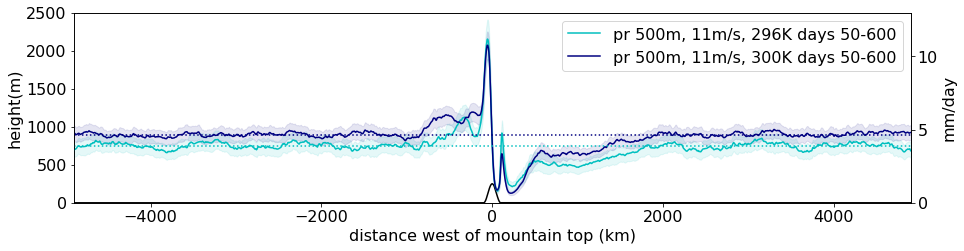

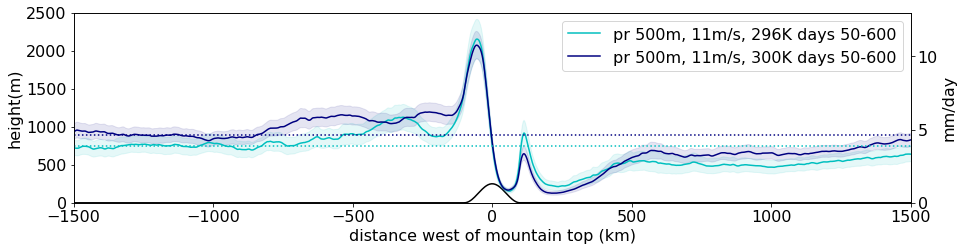

In [46]:
matplotlib.rcParams.update({'font.size':16})
for _ in range(2):
    ax,ax2=plotsection(hrhgt/2,figsize=(15,3.5))
    
    ax2.plot(hrdist,dp500_296Kpr,color='c'   ,label='pr 500m, 11m/s, 296K days 50-600')
    ax2.plot(hrdist,dp500_10pr,color='navy',label='pr 500m, 11m/s, 300K days 50-600')
    
    
    ax2.fill_between(hrdist,dp500_296Kpr-2*dp500_296Kstd/np.sqrt(393),dp500_296Kpr+2*dp500_296Kstd/np.sqrt(393),alpha=0.1,color='c')
    ax2.fill_between(hrdist,dp500_10pr-2*dp500_10std/np.sqrt(1050),dp500_10pr+2*dp500_10std/np.sqrt(1050),alpha=0.1,color='navy')
    
    ax2.axhline(dp500_296Kpr[2200:3000].mean(),color='c'  ,linestyle=':')
    ax2.axhline(dp500_10pr[2200:3000].mean(),color='navy',linestyle=':')
    
    #ax2.plot(xx/1000,Plin_9,color='c',linestyle='--')
    #ax2.plot(xx/1000,Plin_11,color='navy',linestyle='--')
        
    ax2.set_ylabel("mm/day")
    ax2.legend()
    ax.set_xlim(-4900,4900)
    ax.set_ylim(0.,2500.)
    ax2.set_ylim(0.,13.)
ax.set_xlim(-1500,1500)

In [52]:
peakprecipdp500_10   = deepchannel_500concatprecip[:,:,1651:1656]
peakprecipdp500_296K = deepchannel_500_296Kprecip[200:,:,1651:1656]
upstreamprecipdp500_10 = deepchannel_500concatprecip[:,:,2200:3000]
upstreamprecipdp500_296K = deepchannel_500_296Kprecip[200:,:,2200:3000]
print("Peak precip:    ", end=' '); ratio_CI(peakprecipdp500_296K,peakprecipdp500_10,'K',norm=4)
print("Upstream precip:", end=' '); ratio_CI(upstreamprecipdp500_296K,upstreamprecipdp500_10,'K',norm=4)
print("Peak P':        ", end=' '); ratio_CI(peakprecipdp500_296K-upstreamprecipdp500_296K.mean(),peakprecipdp500_10-upstreamprecipdp500_10.mean(),'K',norm=4)


Peak precip:     Change is -0.7 %/K (95% CI = [-4.3 to 2.9])
Upstream precip: Change is 4.6 %/K (95% CI = [3.7 to 5.5])
Peak P':         Change is -3.5 %/K (95% CI = [-8.6 to 1.6])


In [59]:
xx,hx = topographic_profile('cos',A=500)
Pprimelin_296  = linear_precip_theory_N(xx,hx,11,0.012/1.014**4,qfact=1/1.09**4,tauT=7.5,tauq=27.5)-4.
Pprimelin_300  = linear_precip_theory_N(xx,hx,11,0.012,qfact=1.,tauT=7.5,tauq=27.5)-4.

In [60]:
print("Theoretical change in peak P': %.1f %%/K"%(100*(np.max(Pprimelin_300)/np.max(Pprimelin_296)-1)/4))

Theoretical change in peak P': 0.9 %/K


In [11]:
xx,hx = topographic_profile('cos',A=500)
Plin_296  = linear_precip_theory_N(xx,hx,11,0.012/1.014**4,qfact=1/1.09**4,tauT=7.5,tauq=27.5)
Plin_300  = linear_precip_theory_N(xx,hx,11,0.012,qfact=1.,tauT=7.5,tauq=27.5,P0=4*1.03**4)

In [12]:
print("Theoretical change in peak P: %.1f %%/K"%(100*(np.max(Plin_300)/np.max(Plin_296)-1)/4))

Theoretical change in peak P: 1.5 %/K


## T,q,w

In [104]:
p1=5;p2=16
deeptempmean_500_10_p_hat_prime = hatprime(deeptempmean_500_10_p,p1,p2)
deeptempmean_500_296K_p_hat_prime = hatprime(deeptempmean_500_296K_p,p1,p2)

deepqvmean_500_10_p_hat_prime = Lc/cp*hatprime(deepqvmean_500_10_p,p1,p2) # convert to K
deepqvmean_500_296K_p_hat_prime = Lc/cp*hatprime(deepqvmean_500_296K_p,p1,p2) # convert to K

xx,hx = topographic_profile(kind='cos',a=100e3,A=500)
lmTd_hat_linear10,lmqd_hat_linear10     = linear_TdL_qdL_N(xx,hx,10,0.012,qfact=1.) 
lmTd_hat_linear296K,lmqd_hat_linear296K = linear_TdL_qdL_N(xx,hx,10,0.012/1.014**4,qfact=1/1.09**4) 

increase in max, linear theory: T = -2.2%/K,  q = 3.9%/K
increase in max, WRF: T = 6.6%/K,  q = 6.9%/K


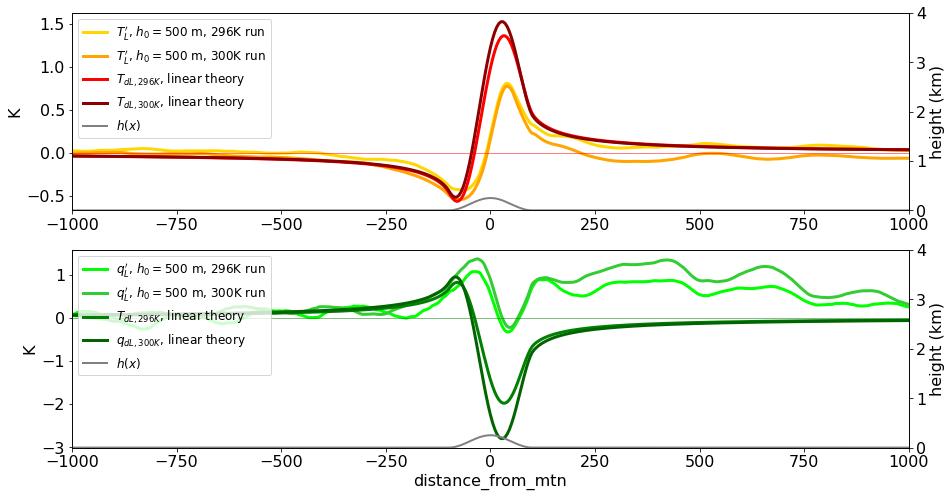

In [66]:
fig,(ax,ax2) = plt.subplots(2,1,figsize=(15,8))
axm=ax.twinx()
ax2m=ax2.twinx()

# Panel a : temperature deviations
deeptempmean_500_296K_p_hat_prime.plot(ax=ax,color='gold'  ,linewidth=3,label=r"$T_L'$, $h_0=500$ m, 296K run")
deeptempmean_500_10_p_hat_prime.plot(ax=ax,color='orange',linewidth=3,label=r"$T_L'$, $h_0=500$ m, 300K run")
ax.plot(xx/1000,lmTd_hat_linear296K,   color='red'    ,linewidth=3,label=r"$T_{dL,296K}$, linear theory")
ax.plot(xx/1000,lmTd_hat_linear10,   color='darkred',linewidth=3,label=r"$T_{dL,300K}$, linear theory")
ax.axhline(0.,linestyle='-',linewidth='0.5',color='red')

# Panel b : moisture deviations
deepqvmean_500_296K_p_hat_prime.plot(ax=ax2,color='lime'     ,linewidth=3,label=r"$q_L'$, $h_0=500$ m, 296K run")
deepqvmean_500_10_p_hat_prime.plot(ax=ax2,color='limegreen',linewidth=3,label=r"$q_L'$, $h_0=500$ m, 300K run")
ax2.plot(xx/1000,lmqd_hat_linear296K,   color='green'    ,linewidth=3,label=r"$T_{dL,296K}$, linear theory")
ax2.plot(xx/1000,lmqd_hat_linear10,   color='darkgreen',linewidth=3,label=r"$q_{dL,300K}$, linear theory")
ax2.axhline(0.,linestyle='-',linewidth='0.5',color='green')


for a,am in (ax,axm),(ax2,ax2m):
    a.set_xlim(-1000,1000)
    a.set_ylabel("K")
    a.legend(fontsize=20)
    
    am.plot(hrdist,hrhgt/2000,label=r"$h(x)$",color='gray',linewidth=2)
    am.set_ylabel('height (km)')
    am.set_ylim(0,4)
    
    lines, labels = a.get_legend_handles_labels()
    lines2, labels2 = am.get_legend_handles_labels()
    a.legend(lines + lines2, labels + labels2,fontsize=12,loc=2)

ax.set_xlabel('')
print("increase in max, linear theory: T = %.1f%%/K,  q = %.1f%%/K"%(100*(lmTd_hat_linear10.min()/lmTd_hat_linear296K.min()-1)/4,100*(lmqd_hat_linear10.max()/lmqd_hat_linear296K.max()-1)/4))
print("increase in max, WRF: T = %.1f%%/K,  q = %.1f%%/K"%(100*(deeptempmean_500_10_p_hat_prime.min()/deeptempmean_500_296K_p_hat_prime.min()-1)/4,100*(deepqvmean_500_10_p_hat_prime.max()/deepqvmean_500_296K_p_hat_prime.max()-1)/4))


## w

In [67]:
%%time
deepchannel_500w  = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/diags/wrf.W.days50-200.nc')
deepchannel_500_neww  = xr.open_dataarray('/global/cscratch1/sd/qnicolas/temp/channel.wrf.100x2.mountain.60lev.500m.new.3km.w_mean_temp.nc')

deepchannel_500_296Kw = deepchannel_500_296K.W[200:].mean(['Time','south_north']).load()
deepchannel_500_296Kw.to_netcdf('/global/cscratch1/sd/qnicolas/temp/channel.wrf.100x2.mountain.60lev.500m.296K.3km.w_mean_temp.nc')
#deepchannel_500_296Kw  = xr.open_dataarray('/global/cscratch1/sd/qnicolas/temp/channel.wrf.100x2.mountain.60lev.500m.296K.3km.w_mean_temp.nc')

CPU times: user 3.8 s, sys: 436 ms, total: 4.24 s
Wall time: 27 s


In [71]:
deepwmean_500_10 = change_coords_eta(deepinput_500,0.5*(deepchannel_500w+deepchannel_500_neww),staggered=True)
deepwmean_500_10_p = interp_eta_to_pressure(deepchannel_500_new,deepwmean_500_10,1,dsinput=deepinput_500)

deepwmean_500_296K_p = interp_eta_to_pressure(deepchannel_500_296K,change_coords_eta(deepinput_500_296K,deepchannel_500_296Kw,staggered=True),1,dsinput=deepinput_500_296K)

In [74]:
xx,hx = topographic_profile(kind='cos',a=100e3,A=500)
linear_w_10 = linear_w_1layer(xx,hx,np.arange(0,20000,200.),10,0.012) 
linear_w_296K = linear_w_1layer(xx,hx,np.arange(0,20000,200.),10,0.012/1.014**4) 


(-0.07, 0.07)

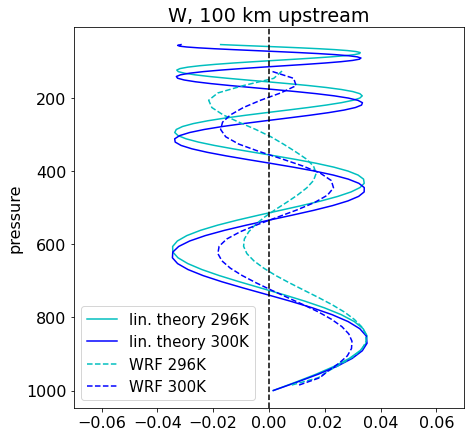

In [75]:
_,ax=plt.subplots(1,1,figsize=(7,7))

linear_w_296K.sel(distance_from_mtn=-100,method='nearest').plot(ax=ax,y='pressure',yincrease=False,color='c',label='lin. theory 296K')
linear_w_10.sel(distance_from_mtn=-100,method='nearest').plot(ax=ax,y='pressure',yincrease=False,color='b',label='lin. theory 300K')

deepwmean_500_296K_p.sel(distance_from_mtn=-100,method='nearest').plot(ax=ax,y='pressure',yincrease=False,color='c',linestyle='--',label='WRF 296K')
deepwmean_500_10_p.sel(distance_from_mtn=-100,method='nearest').plot(ax=ax,y='pressure',yincrease=False,color='b',linestyle='--',label='WRF 300K')
ax.axvline(0.,color='k',linestyle='--')
ax.set_title("W, 100 km upstream")
ax.legend(fontsize=15)
ax.set_xlim(-0.07,0.07)

In [49]:
tprime300 = deeptempmean_500_10_p.sel(distance_from_mtn=-102) - deeptempmean_500_10_p.sel(distance_from_mtn=-2001)
tprime296= deeptempmean_500_296K_p.sel(distance_from_mtn=-102) - deeptempmean_500_296K_p.sel(distance_from_mtn=-2001)

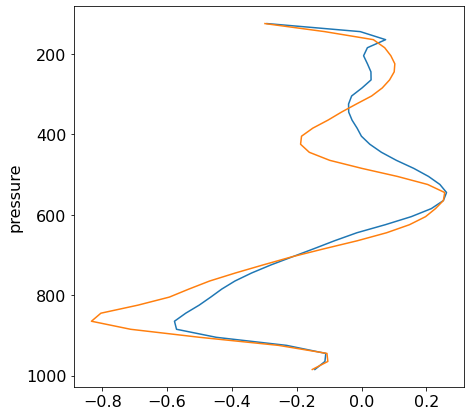

In [50]:
plt.figure(figsize=(7,7))
tprime296.plot(y='pressure',yincrease=False)
tprime300.plot(y='pressure',yincrease=False)

In [51]:
qprime300 = deepqvmean_500_10_p.sel(distance_from_mtn=-102) - deepqvmean_500_10_p.sel(distance_from_mtn=-2001)
qprime296= deepqvmean_500_296K_p.sel(distance_from_mtn=-102) - deepqvmean_500_296K_p.sel(distance_from_mtn=-2001)

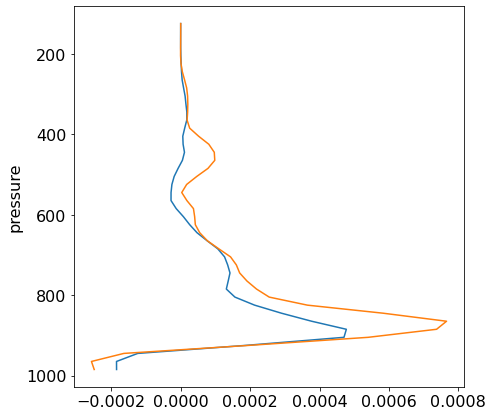

In [52]:
plt.figure(figsize=(7,7))
qprime296.plot(y='pressure',yincrease=False)
qprime300.plot(y='pressure',yincrease=False)

## Ahmed BL

In [17]:
import metpy.calc as mpcalc

In [46]:
def BL_wrf_sigmalevs(t,q,p,lft_top_pressure):
    t_dew = mpcalc.dewpoint_from_specific_humidity(np.array(q), np.array(t)*units.K, np.array(p)*units.Pa)
    zero_array = 0.*p
    thetae = zero_array+np.array(mpcalc.equivalent_potential_temperature(np.array(p)*units.Pa,
                                                                         np.array(t)*units.K,
                                                                         t_dew
                                                                        )/units.K)
    thetaestar = zero_array+np.array(mpcalc.saturation_equivalent_potential_temperature(np.array(p)*units.Pa,
                                                                                        np.array(t)*units.K
                                                                                       )/units.K)
    
    kappaL=3
    g=9.81
    wB = 0.52
    wL = 1-wB
    thetae0 = 340
    
    thetaeB = thetae[:6].mean('bottom_top')
    thetaeL = thetae[6:].where(p[6:]>lft_top_pressure*100).mean('bottom_top')
    thetaeLstar = thetaestar[6:].where(p[6:]>lft_top_pressure*100).mean('bottom_top')
    
    capeL  = change_coords_sfc((thetaeB/thetaeLstar - 1)*thetae0)
    subsatL = change_coords_sfc((1 - thetaeL/thetaeLstar)*thetae0)
    BL = g/kappaL/thetae0*(wB*capeL-wL*subsatL)
    
    return BL

In [ ]:
dp500_296Kpr
dp500_10pr 



In [26]:
deepchannel_500pres      = (deepinput_500.PB[0,:,0] + deepchannel_500.P[200:].mean(('Time','south_north'))).compute()
deepchannel_500_newpres  = (deepinput_500.PB[0,:,0] + deepchannel_500_new.P[200:].mean(('Time','south_north'))).compute()
deepchannel_500_296Kpres = (deepinput_500_296K.PB[0,:,0] + deepchannel_500_296K.P[200:].mean(('Time','south_north'))).compute()

In [27]:
dp500_10temp   = 0.5*(deepchannel_500theta*(deepchannel_500pres/1e5)**0.286+deepchannel_500_newtheta*(deepchannel_500_newpres/1e5)**0.286)
dp500_296Ktemp = deepchannel_500_296Ktheta*(deepchannel_500_296Kpres/1e5)**0.286

dp500_10qv   = 0.5*(deepchannel_500qv+deepchannel_500_newqv)
dp500_296Kqv = deepchannel_500_296Kqv

In [47]:
BL10   = BL_wrf_sigmalevs(dp500_10temp,dp500_10qv,0.5*(deepchannel_500pres+deepchannel_500_newpres),700)
BL296K = BL_wrf_sigmalevs(dp500_296Ktemp,dp500_296Kqv,deepchannel_500_296Kpres,700)


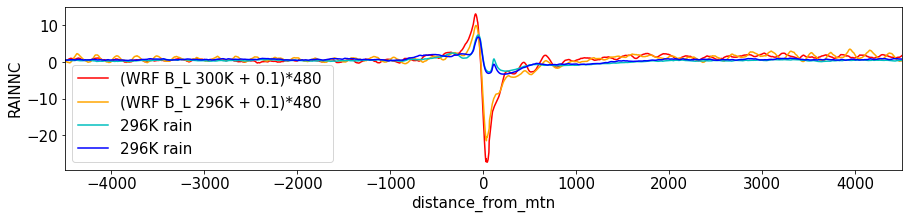

In [71]:
plt.figure(figsize=(15,3))
((BL10+0.105)*480).plot(label='(WRF B_L 300K + 0.1)*480 ',color='r')
((BL296K+0.07)*480).plot(label='(WRF B_L 296K + 0.1)*480 ',color='orange')

((change_coords_sfc(dp500_296Kpr)-3.5)).plot(label='296K rain',color='c')
((change_coords_sfc(dp500_10pr)-4)).plot(label='296K rain',color='b')

#plt.ylim(0,25)
plt.xlim(-4500,4500)
plt.legend()

In [49]:
def subsat_wrf_sigmalevs(t,q,p,lft_top_pressure):
    t_dew = mpcalc.dewpoint_from_specific_humidity(np.array(q), np.array(t)*units.K, np.array(p)*units.Pa)
    zero_array = 0.*p
    thetae = zero_array+np.array(mpcalc.equivalent_potential_temperature(np.array(p)*units.Pa,
                                                                         np.array(t)*units.K,
                                                                         t_dew
                                                                        )/units.K)
    thetaestar = zero_array+np.array(mpcalc.saturation_equivalent_potential_temperature(np.array(p)*units.Pa,
                                                                                        np.array(t)*units.K
                                                                                       )/units.K)
    
    kappaL=3
    g=9.81
    wB = 0.52
    wL = 1-wB
    thetae0 = 340
    
    thetaeB = thetae[:6].mean('bottom_top')
    thetaeL = thetae[6:].where(p[6:]>lft_top_pressure*100).mean('bottom_top')
    thetaeLstar = thetaestar[6:].where(p[6:]>lft_top_pressure*100).mean('bottom_top')
    
    relative_subsat = change_coords_sfc(1 - thetaeL/thetaeLstar)
    absolute_subsat = change_coords_sfc(thetaeLstar - thetaeL)
    return relative_subsat,absolute_subsat

In [50]:
relsubsat10  , abssubsat10    = subsat_wrf_sigmalevs(dp500_10temp,dp500_10qv,0.5*(deepchannel_500pres+deepchannel_500_newpres),700)
relsubsat296K, abssubsat296K  = subsat_wrf_sigmalevs(dp500_296Ktemp,dp500_296Kqv,deepchannel_500_296Kpres,700)


(0.0, 0.08)

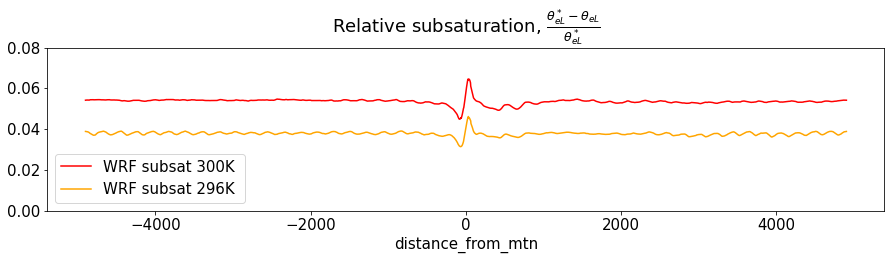

In [57]:
plt.figure(figsize=(15,3))
relsubsat10  .plot(label='WRF subsat 300K ',color='r')
relsubsat296K.plot(label='WRF subsat 296K ',color='orange')
plt.legend()
plt.title(r"Relative subsaturation, $\frac{\theta_{eL}^*-\theta_{eL}}{\theta_{eL}^*}$");None
plt.ylim(0.,0.08)

(0.0, 25.0)

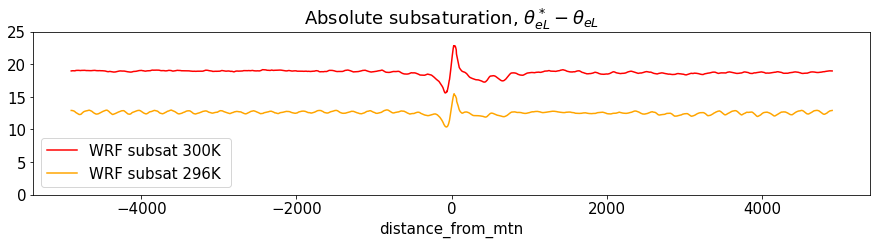

In [59]:
plt.figure(figsize=(15,3))
abssubsat10  .plot(label='WRF subsat 300K ',color='r')
abssubsat296K.plot(label='WRF subsat 296K ',color='orange')
plt.legend()
plt.title(r"Absolute subsaturation, $\theta_{eL}^*-\theta_{eL}$");None
plt.ylim(0.,25)

(0.8, 1.2)

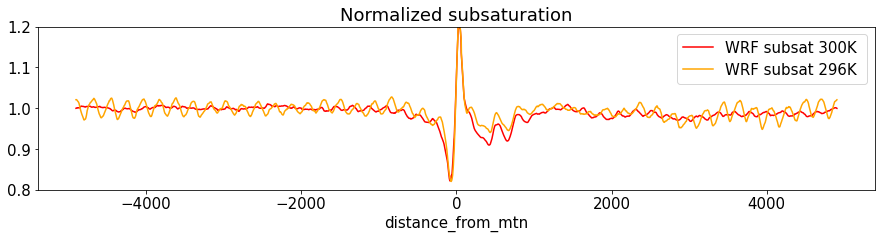

In [62]:
plt.figure(figsize=(15,3))
(abssubsat10/abssubsat10[2000:3000].mean())  .plot(label='WRF subsat 300K ',color='r')
(abssubsat296K/abssubsat296K[2000:3000].mean()).plot(label='WRF subsat 296K ',color='orange')
plt.legend()
plt.title(r"Normalized subsaturation");None
plt.ylim(0.8,1.2)

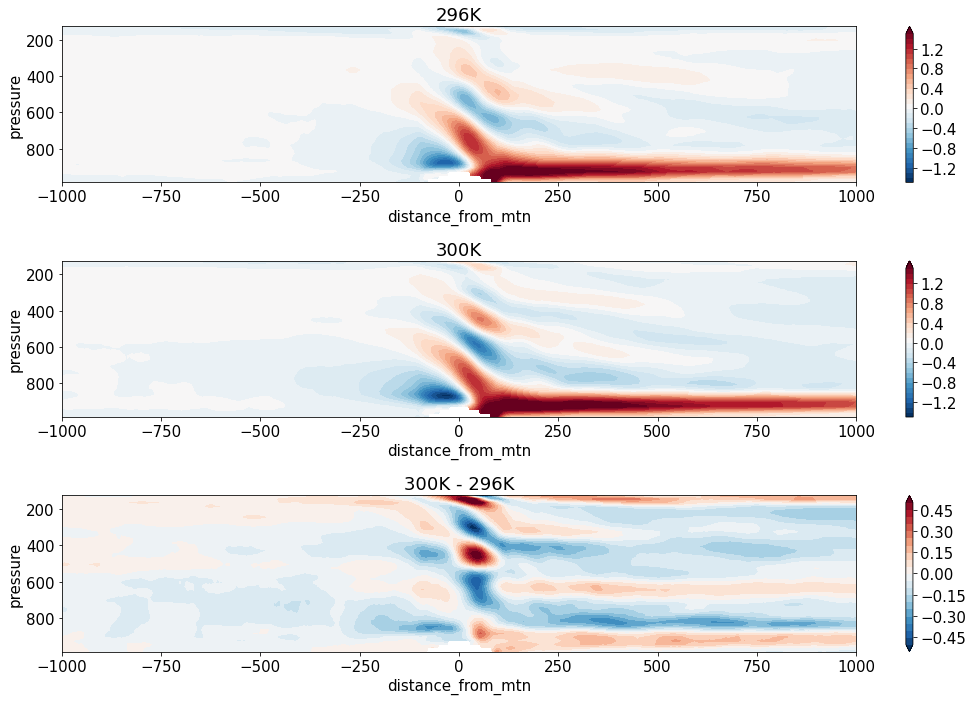

In [89]:
fig,(ax1,ax2,ax3)=plt.subplots(3,1,figsize=(15,10))
lvls = np.arange(-1.5,1.6,0.1)

deeptprimemean_500_296K_p = deeptempmean_500_296K_p - deeptempmean_500_296K_p[:,2000:3000].mean('distance_from_mtn')
deeptprimemean_500_296K_p.plot.contourf(ax=ax1,yincrease=False,levels=lvls)
ax1.set_title("296K")

deeptprimemean_500_10_p = deeptempmean_500_10_p - deeptempmean_500_10_p[:,2000:3000].mean('distance_from_mtn')
deeptprimemean_500_10_p.plot.contourf(ax=ax2,yincrease=False,levels=lvls)
ax2.set_title("300K")

(deeptprimemean_500_10_p-deeptprimemean_500_296K_p).plot.contourf(ax=ax3,yincrease=False,levels=np.arange(-0.5,0.501,0.05))
ax3.set_title("300K - 296K")


for ax in (ax1,ax2,ax3):
    ax.set_xlim(-1000,1000)
fig.tight_layout()

(-10.0, 10.0)

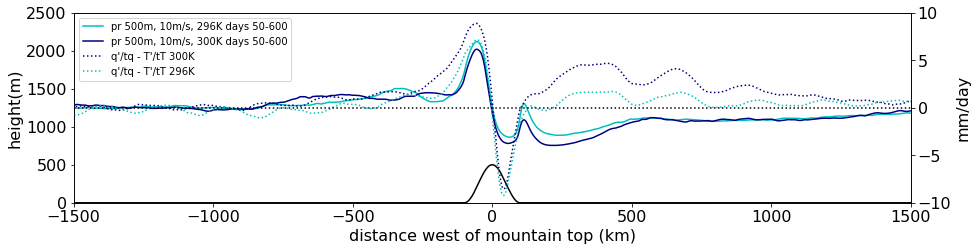

In [113]:
ax,ax2=plotsection(hrhgt,figsize=(15,3.5))

ax2.plot(hrdist,dp500_296Kpr-dp500_296Kpr[2200:3000].mean(),color='c'   ,label='pr 500m, 10m/s, 296K days 50-600')
ax2.plot(hrdist,dp500_10pr-dp500_10pr[2200:3000].mean(),color='navy',label='pr 500m, 10m/s, 300K days 50-600')

ptest10.plot(ax=ax2,color='navy',linestyle=':',label="q'/tq - T'/tT 300K ")
ptest296K.plot(ax=ax2,color='c',linestyle=':',label="q'/tq - T'/tT 296K ")

ax2.axhline(0.,color='k'  ,linestyle=':')

ax2.set_ylabel("mm/day")
ax2.legend(loc=2,fontsize=10)
ax.set_xlim(-1500,1500)
ax.set_ylim(0.,2500.)
ax2.set_ylim(-10.,10.)

In [ ]:
deeptempmean_500_296K_p_hat_prime.plot(ax=ax,color='gold'  ,linewidth=3,label=r"$T_L'$, $h_0=500$ m, 296K run")
deeptempmean_500_10_p_hat_prime.plot(ax=ax,color='orange',linewidth=3,label=r"$T_L'$, $h_0=500$ m, 300K run")
deepqvmean_500_296K_p_hat_prime.plot(ax=ax2,color='lime'     ,linewidth=3,label=r"$q_L'$, $h_0=500$ m, 296K run")
deepqvmean_500_10_p_hat_prime.plot(ax=ax2,color='limegreen',linewidth=3,label=r"$q_L'$, $h_0=500$ m, 300K run")


In [106]:
ptest10 = 8000/2.5e6*86400*1004. * (-deeptempmean_500_10_p_hat_prime/(7.5*3600)+deepqvmean_500_10_p_hat_prime/(27.5*3600))

In [111]:
ptest296K = 8000/2.5e6*86400*1004. * (-deeptempmean_500_296K_p_hat_prime/(7.5*3600)+deepqvmean_500_296K_p_hat_prime/(27.5*3600))